# Enhancing Image Reconstruction with Prediction model using DCGAN

#### This project aims in performing Image Reconstruction by implementing an Image Prediction model.
The project is perofrmed in 3 phases:
1. Training Phase
2. Prediction Phase
3. Inpainting Phase

All three phases are implemented on three datasets:
1. Celeb-A Faces Dataset
2. Flowers Dataset
3. Pokemon Dataset

These datasets are selected based on the nature of their image complexity and are evaluated based on Inception Score and Model Losses. 

The Pytorch Library is used for performing Deep Learning tasks.

### Experiment 1: Celeb-A Faces Dataset

This experiment is based on 1st scenario where Celeb-A Faces Dataset is selected. The images in the dataset have a similar pattern (face images) and the features are also same (e.g. eyes, nose, mouth, etc.) with a small difference considering shades and extra features (e.g. hat, eyeglasses, etc.).

The aim with this dataset is to achieve better results than other two because of its image nature.

In [1]:
# Loading required packages
import os
import cv2
import glob
import torch
import random
import imageio
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torchvision.datasets as dsets
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import mpmath
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray, expand_dims, log, mean, exp
from image_utils import get_tensor_image, save_tensor_images

In [2]:
# Creating a Cuda Environment 
cudnn.benchmark = True

# Set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  7436


# I. Training DCGAN


In [3]:
# Initializing Hyperparameters for the model.
image_size = 64
nz = 100
nc = 3
D_output_dim = 1
ngf = 128
ndf = 128
ngpu = 1

learning_rate = 0.0002
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 20
data_dir = './data/celeba/resized_celeba/train'
def save_checkpoint(state, filename="./data/celeba/checkpoints/checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

In [4]:
# Performing transformation and loading the dataset.
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

celebA_data = dsets.ImageFolder(data_dir, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=celebA_data,
                                          batch_size=batch_size,
                                          shuffle=True)

# Checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, " will be used.\n")

cuda  will be used.



## Generator Network

The Generator network is a neual network that takes a noise vector as an input and generates an image after passing through several hidden layers.

The DCGAN generator has Transpose Convolution layers and includes batch normalization instead of pooling payers.

The output of the network is a Tanh Function providing input to the Discriminator network.

In [5]:
#The Generator Neural Network Model 
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
            return output

NetG = Generator(ngpu).to(device)
print(NetG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


## Discriminator Network

The Discriminator network is a neual network that takes real dataset images as an input and it passes through several hidden layers.

The DCGAN generator has Convolution layers and includes batch normalization instead of pooling payers.

It also uses LeakyReLU Activation function and the output of the network is a Sigmoid Function acting as a classifier network.

In [6]:
#The Discriminator Neural Network Model 
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

NetD = Discriminator(ngpu).to(device)
print(NetD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [7]:
# Initializing the Loss function.
criterion = torch.nn.BCELoss()

#Creating Noise input for the Generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Initializing Network Optimizers
G_optimizer = torch.optim.Adam(NetG.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(NetD.parameters(), lr=learning_rate, betas=betas)

G_losses = []
D_losses = []
img_list = []
iters = 0

In [8]:
# Training the DCGAN model

print("Starting Training Loop...")
for epoch in range(num_epochs):
    
    if epoch % 5 == 0:
        checkpoint = {'state_dict1' : NetD.state_dict(), 
                      'optimizer1': D_optimizer.state_dict(),
                     'state_dict2' : NetG.state_dict(), 
                      'optimizer2': G_optimizer.state_dict()}
        save_checkpoint(checkpoint)
    
    for i, (images,targets) in enumerate(data_loader, 0):
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        NetD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real = images.to(device)
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0])*0.9).to(device)
        output = NetD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
        fake = NetG(noise)
        target = Variable(torch.zeros(input.size()[0])*0.1).to(device)
        output = NetD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        D_optimizer.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        NetG.zero_grad()
        target = Variable(torch.ones(input.size()[0])).to(device)
        output = NetD(fake)
        errG = criterion(output, target)
        errG.backward()
        G_optimizer.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, num_epochs, i, len(data_loader), errD.data, errG.data))
        
        # loss values
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = NetG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./data/celeba/new_results_10epochs", normalize = True)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./data/celeba/new_results_10epochs", epoch), 
                              normalize = True)

Starting Training Loop...
=> Saving Checkpoint
[0/20][0/945] Loss_D: 1.5079 Loss_G: 9.2694
[0/20][1/945] Loss_D: 1.8536 Loss_G: 12.5723
[0/20][2/945] Loss_D: 1.1462 Loss_G: 6.3239
[0/20][3/945] Loss_D: 3.1296 Loss_G: 15.6349
[0/20][4/945] Loss_D: 0.7882 Loss_G: 14.5340
[0/20][5/945] Loss_D: 0.5389 Loss_G: 7.7325
[0/20][6/945] Loss_D: 1.1905 Loss_G: 17.1792
[0/20][7/945] Loss_D: 0.5837 Loss_G: 17.2232
[0/20][8/945] Loss_D: 0.6010 Loss_G: 13.2255
[0/20][9/945] Loss_D: 0.5353 Loss_G: 6.3520
[0/20][10/945] Loss_D: 2.1554 Loss_G: 21.1431
[0/20][11/945] Loss_D: 0.7961 Loss_G: 21.4178
[0/20][12/945] Loss_D: 0.5488 Loss_G: 19.9825
[0/20][13/945] Loss_D: 0.5495 Loss_G: 17.9694
[0/20][14/945] Loss_D: 0.5570 Loss_G: 14.7876
[0/20][15/945] Loss_D: 0.4685 Loss_G: 10.1161
[0/20][16/945] Loss_D: 0.5730 Loss_G: 8.3642
[0/20][17/945] Loss_D: 0.6522 Loss_G: 16.3461
[0/20][18/945] Loss_D: 0.6126 Loss_G: 15.8445
[0/20][19/945] Loss_D: 0.4974 Loss_G: 13.0586
[0/20][20/945] Loss_D: 0.4852 Loss_G: 8.3830
[0/

[0/20][179/945] Loss_D: 0.6889 Loss_G: 4.1429
[0/20][180/945] Loss_D: 0.5888 Loss_G: 3.4156
[0/20][181/945] Loss_D: 0.6709 Loss_G: 3.8637
[0/20][182/945] Loss_D: 0.7201 Loss_G: 2.1035
[0/20][183/945] Loss_D: 1.0036 Loss_G: 6.8839
[0/20][184/945] Loss_D: 2.0272 Loss_G: 2.5880
[0/20][185/945] Loss_D: 0.8404 Loss_G: 2.5815
[0/20][186/945] Loss_D: 0.7811 Loss_G: 3.0270
[0/20][187/945] Loss_D: 0.6929 Loss_G: 2.4960
[0/20][188/945] Loss_D: 0.7112 Loss_G: 2.6526
[0/20][189/945] Loss_D: 0.6974 Loss_G: 2.6583
[0/20][190/945] Loss_D: 0.6997 Loss_G: 3.2919
[0/20][191/945] Loss_D: 0.7023 Loss_G: 3.2936
[0/20][192/945] Loss_D: 0.7858 Loss_G: 3.6981
[0/20][193/945] Loss_D: 0.8834 Loss_G: 2.2009
[0/20][194/945] Loss_D: 1.0184 Loss_G: 7.8148
[0/20][195/945] Loss_D: 3.0025 Loss_G: 0.6977
[0/20][196/945] Loss_D: 2.3664 Loss_G: 6.5175
[0/20][197/945] Loss_D: 2.3770 Loss_G: 3.7248
[0/20][198/945] Loss_D: 0.8532 Loss_G: 1.0286
[0/20][199/945] Loss_D: 1.5681 Loss_G: 2.9874
[0/20][200/945] Loss_D: 0.8563 Los

[0/20][358/945] Loss_D: 0.7211 Loss_G: 4.0237
[0/20][359/945] Loss_D: 1.0412 Loss_G: 1.6301
[0/20][360/945] Loss_D: 1.4441 Loss_G: 6.8755
[0/20][361/945] Loss_D: 1.8206 Loss_G: 3.7243
[0/20][362/945] Loss_D: 0.6729 Loss_G: 1.5998
[0/20][363/945] Loss_D: 1.5559 Loss_G: 5.6214
[0/20][364/945] Loss_D: 1.2012 Loss_G: 3.7643
[0/20][365/945] Loss_D: 0.7474 Loss_G: 1.6190
[0/20][366/945] Loss_D: 1.4401 Loss_G: 4.7910
[0/20][367/945] Loss_D: 1.3701 Loss_G: 2.6599
[0/20][368/945] Loss_D: 0.8392 Loss_G: 2.1754
[0/20][369/945] Loss_D: 0.9336 Loss_G: 3.6956
[0/20][370/945] Loss_D: 1.1247 Loss_G: 1.9171
[0/20][371/945] Loss_D: 1.1528 Loss_G: 3.3748
[0/20][372/945] Loss_D: 0.8418 Loss_G: 2.8581
[0/20][373/945] Loss_D: 0.6738 Loss_G: 2.6929
[0/20][374/945] Loss_D: 0.8146 Loss_G: 4.1511
[0/20][375/945] Loss_D: 0.9577 Loss_G: 2.5071
[0/20][376/945] Loss_D: 0.9498 Loss_G: 3.4266
[0/20][377/945] Loss_D: 0.7983 Loss_G: 2.9578
[0/20][378/945] Loss_D: 0.8514 Loss_G: 3.4064
[0/20][379/945] Loss_D: 0.7589 Los

[0/20][537/945] Loss_D: 0.7291 Loss_G: 3.3834
[0/20][538/945] Loss_D: 0.6127 Loss_G: 3.4368
[0/20][539/945] Loss_D: 0.6968 Loss_G: 3.9812
[0/20][540/945] Loss_D: 0.7772 Loss_G: 2.4803
[0/20][541/945] Loss_D: 0.8909 Loss_G: 5.6453
[0/20][542/945] Loss_D: 1.3169 Loss_G: 1.7052
[0/20][543/945] Loss_D: 1.3728 Loss_G: 5.9700
[0/20][544/945] Loss_D: 1.1711 Loss_G: 3.5308
[0/20][545/945] Loss_D: 0.6038 Loss_G: 2.5781
[0/20][546/945] Loss_D: 0.8256 Loss_G: 4.3519
[0/20][547/945] Loss_D: 0.8535 Loss_G: 2.6943
[0/20][548/945] Loss_D: 0.8195 Loss_G: 2.5093
[0/20][549/945] Loss_D: 0.9040 Loss_G: 5.0409
[0/20][550/945] Loss_D: 0.8627 Loss_G: 2.6053
[0/20][551/945] Loss_D: 0.8543 Loss_G: 4.3371
[0/20][552/945] Loss_D: 0.6393 Loss_G: 3.3069
[0/20][553/945] Loss_D: 0.7137 Loss_G: 3.3023
[0/20][554/945] Loss_D: 0.7711 Loss_G: 4.7707
[0/20][555/945] Loss_D: 1.0269 Loss_G: 1.4684
[0/20][556/945] Loss_D: 1.7666 Loss_G: 8.9390
[0/20][557/945] Loss_D: 3.5082 Loss_G: 5.2338
[0/20][558/945] Loss_D: 1.0311 Los

[0/20][716/945] Loss_D: 0.6329 Loss_G: 3.5420
[0/20][717/945] Loss_D: 0.7210 Loss_G: 2.5765
[0/20][718/945] Loss_D: 0.7939 Loss_G: 3.0337
[0/20][719/945] Loss_D: 0.7610 Loss_G: 2.5223
[0/20][720/945] Loss_D: 0.5789 Loss_G: 2.8256
[0/20][721/945] Loss_D: 0.5989 Loss_G: 4.2842
[0/20][722/945] Loss_D: 0.7648 Loss_G: 3.4739
[0/20][723/945] Loss_D: 0.6308 Loss_G: 2.6243
[0/20][724/945] Loss_D: 0.5438 Loss_G: 3.9179
[0/20][725/945] Loss_D: 0.6151 Loss_G: 4.4482
[0/20][726/945] Loss_D: 0.7425 Loss_G: 1.5629
[0/20][727/945] Loss_D: 0.7272 Loss_G: 5.6546
[0/20][728/945] Loss_D: 0.5870 Loss_G: 3.4079
[0/20][729/945] Loss_D: 0.4463 Loss_G: 3.6527
[0/20][730/945] Loss_D: 0.5503 Loss_G: 4.7058
[0/20][731/945] Loss_D: 0.5769 Loss_G: 4.7898
[0/20][732/945] Loss_D: 0.7423 Loss_G: 1.6027
[0/20][733/945] Loss_D: 1.1532 Loss_G: 8.0756
[0/20][734/945] Loss_D: 2.7226 Loss_G: 3.1019
[0/20][735/945] Loss_D: 0.6293 Loss_G: 1.6029
[0/20][736/945] Loss_D: 1.3445 Loss_G: 5.6699
[0/20][737/945] Loss_D: 1.8364 Los

[0/20][895/945] Loss_D: 3.4877 Loss_G: 6.0175
[0/20][896/945] Loss_D: 0.6773 Loss_G: 1.4391
[0/20][897/945] Loss_D: 1.1165 Loss_G: 3.3091
[0/20][898/945] Loss_D: 0.6140 Loss_G: 4.1771
[0/20][899/945] Loss_D: 0.8312 Loss_G: 2.3339
[0/20][900/945] Loss_D: 0.7773 Loss_G: 1.8045
[0/20][901/945] Loss_D: 0.8013 Loss_G: 3.2007
[0/20][902/945] Loss_D: 0.8236 Loss_G: 2.2254
[0/20][903/945] Loss_D: 0.7359 Loss_G: 2.4879
[0/20][904/945] Loss_D: 0.8298 Loss_G: 2.0784
[0/20][905/945] Loss_D: 0.8084 Loss_G: 2.5510
[0/20][906/945] Loss_D: 0.8591 Loss_G: 2.3741
[0/20][907/945] Loss_D: 0.8613 Loss_G: 2.0880
[0/20][908/945] Loss_D: 0.6938 Loss_G: 3.2949
[0/20][909/945] Loss_D: 0.6627 Loss_G: 2.8786
[0/20][910/945] Loss_D: 0.7615 Loss_G: 2.7266
[0/20][911/945] Loss_D: 0.6105 Loss_G: 3.4730
[0/20][912/945] Loss_D: 0.5712 Loss_G: 3.5693
[0/20][913/945] Loss_D: 0.6467 Loss_G: 2.7988
[0/20][914/945] Loss_D: 0.5295 Loss_G: 3.4944
[0/20][915/945] Loss_D: 1.0543 Loss_G: 6.9563
[0/20][916/945] Loss_D: 2.8238 Los

[1/20][131/945] Loss_D: 2.8849 Loss_G: 3.1176
[1/20][132/945] Loss_D: 0.5938 Loss_G: 1.1760
[1/20][133/945] Loss_D: 1.6786 Loss_G: 6.4251
[1/20][134/945] Loss_D: 2.4987 Loss_G: 4.0124
[1/20][135/945] Loss_D: 0.7118 Loss_G: 1.2934
[1/20][136/945] Loss_D: 1.3440 Loss_G: 3.1912
[1/20][137/945] Loss_D: 0.6259 Loss_G: 3.7445
[1/20][138/945] Loss_D: 0.9731 Loss_G: 1.9300
[1/20][139/945] Loss_D: 0.9710 Loss_G: 3.3579
[1/20][140/945] Loss_D: 0.8808 Loss_G: 2.6480
[1/20][141/945] Loss_D: 0.7683 Loss_G: 2.6608
[1/20][142/945] Loss_D: 0.6980 Loss_G: 3.1382
[1/20][143/945] Loss_D: 0.8907 Loss_G: 2.2109
[1/20][144/945] Loss_D: 0.6686 Loss_G: 3.4261
[1/20][145/945] Loss_D: 0.8510 Loss_G: 3.4015
[1/20][146/945] Loss_D: 0.9292 Loss_G: 1.7498
[1/20][147/945] Loss_D: 0.9788 Loss_G: 5.0062
[1/20][148/945] Loss_D: 1.1459 Loss_G: 2.0323
[1/20][149/945] Loss_D: 0.8149 Loss_G: 4.1134
[1/20][150/945] Loss_D: 0.5437 Loss_G: 3.7835
[1/20][151/945] Loss_D: 0.6552 Loss_G: 2.5907
[1/20][152/945] Loss_D: 0.6181 Los

[1/20][310/945] Loss_D: 0.6622 Loss_G: 2.7505
[1/20][311/945] Loss_D: 0.5662 Loss_G: 2.7682
[1/20][312/945] Loss_D: 0.6660 Loss_G: 3.1931
[1/20][313/945] Loss_D: 0.7336 Loss_G: 4.0625
[1/20][314/945] Loss_D: 0.7317 Loss_G: 2.6070
[1/20][315/945] Loss_D: 0.4488 Loss_G: 3.3732
[1/20][316/945] Loss_D: 1.1521 Loss_G: 6.7358
[1/20][317/945] Loss_D: 2.3696 Loss_G: 4.5055
[1/20][318/945] Loss_D: 0.6121 Loss_G: 1.5143
[1/20][319/945] Loss_D: 1.2661 Loss_G: 4.7733
[1/20][320/945] Loss_D: 0.4888 Loss_G: 4.5808
[1/20][321/945] Loss_D: 0.7161 Loss_G: 2.1761
[1/20][322/945] Loss_D: 0.7209 Loss_G: 3.1202
[1/20][323/945] Loss_D: 0.4899 Loss_G: 3.3774
[1/20][324/945] Loss_D: 1.0509 Loss_G: 4.5613
[1/20][325/945] Loss_D: 1.1620 Loss_G: 3.0418
[1/20][326/945] Loss_D: 0.6131 Loss_G: 2.5627
[1/20][327/945] Loss_D: 0.4918 Loss_G: 3.4235
[1/20][328/945] Loss_D: 0.5270 Loss_G: 3.1359
[1/20][329/945] Loss_D: 0.5326 Loss_G: 2.9616
[1/20][330/945] Loss_D: 0.6292 Loss_G: 2.9382
[1/20][331/945] Loss_D: 0.4615 Los

[1/20][489/945] Loss_D: 0.5723 Loss_G: 3.7638
[1/20][490/945] Loss_D: 0.7430 Loss_G: 4.1992
[1/20][491/945] Loss_D: 1.2080 Loss_G: 1.3915
[1/20][492/945] Loss_D: 0.9927 Loss_G: 5.0315
[1/20][493/945] Loss_D: 0.9950 Loss_G: 1.6283
[1/20][494/945] Loss_D: 0.6083 Loss_G: 3.4017
[1/20][495/945] Loss_D: 0.7858 Loss_G: 5.4080
[1/20][496/945] Loss_D: 0.9614 Loss_G: 3.1312
[1/20][497/945] Loss_D: 0.4786 Loss_G: 3.1336
[1/20][498/945] Loss_D: 0.4017 Loss_G: 4.2001
[1/20][499/945] Loss_D: 0.5859 Loss_G: 3.6381
[1/20][500/945] Loss_D: 0.6059 Loss_G: 2.9975
[1/20][501/945] Loss_D: 0.8654 Loss_G: 5.4708
[1/20][502/945] Loss_D: 1.0725 Loss_G: 2.3519
[1/20][503/945] Loss_D: 0.4998 Loss_G: 2.6704
[1/20][504/945] Loss_D: 0.5163 Loss_G: 4.2120
[1/20][505/945] Loss_D: 0.6199 Loss_G: 2.8126
[1/20][506/945] Loss_D: 0.4748 Loss_G: 2.8393
[1/20][507/945] Loss_D: 0.3659 Loss_G: 4.4404
[1/20][508/945] Loss_D: 0.5453 Loss_G: 3.6735
[1/20][509/945] Loss_D: 0.4661 Loss_G: 4.7615
[1/20][510/945] Loss_D: 0.4212 Los

[1/20][668/945] Loss_D: 0.4697 Loss_G: 4.7001
[1/20][669/945] Loss_D: 0.6005 Loss_G: 2.3918
[1/20][670/945] Loss_D: 0.8995 Loss_G: 7.9581
[1/20][671/945] Loss_D: 2.0045 Loss_G: 2.5667
[1/20][672/945] Loss_D: 0.6614 Loss_G: 2.5672
[1/20][673/945] Loss_D: 1.5690 Loss_G: 9.5061
[1/20][674/945] Loss_D: 4.7596 Loss_G: 5.5004
[1/20][675/945] Loss_D: 1.8514 Loss_G: 0.6841
[1/20][676/945] Loss_D: 1.9053 Loss_G: 2.0979
[1/20][677/945] Loss_D: 0.7405 Loss_G: 3.4848
[1/20][678/945] Loss_D: 0.8458 Loss_G: 2.3410
[1/20][679/945] Loss_D: 0.7231 Loss_G: 1.9345
[1/20][680/945] Loss_D: 0.8597 Loss_G: 3.0255
[1/20][681/945] Loss_D: 0.8150 Loss_G: 2.5231
[1/20][682/945] Loss_D: 0.8330 Loss_G: 2.0636
[1/20][683/945] Loss_D: 0.8148 Loss_G: 2.5959
[1/20][684/945] Loss_D: 0.8385 Loss_G: 2.6374
[1/20][685/945] Loss_D: 0.8319 Loss_G: 2.2260
[1/20][686/945] Loss_D: 0.8303 Loss_G: 2.7125
[1/20][687/945] Loss_D: 0.7003 Loss_G: 2.5396
[1/20][688/945] Loss_D: 0.7694 Loss_G: 2.8273
[1/20][689/945] Loss_D: 0.7094 Los

[1/20][847/945] Loss_D: 0.4887 Loss_G: 3.8330
[1/20][848/945] Loss_D: 0.3944 Loss_G: 4.3473
[1/20][849/945] Loss_D: 0.4649 Loss_G: 3.0352
[1/20][850/945] Loss_D: 0.4411 Loss_G: 3.6638
[1/20][851/945] Loss_D: 0.5721 Loss_G: 3.1640
[1/20][852/945] Loss_D: 0.4593 Loss_G: 2.9768
[1/20][853/945] Loss_D: 0.4173 Loss_G: 3.9519
[1/20][854/945] Loss_D: 0.4295 Loss_G: 4.6540
[1/20][855/945] Loss_D: 0.4378 Loss_G: 4.4247
[1/20][856/945] Loss_D: 1.0279 Loss_G: 8.6730
[1/20][857/945] Loss_D: 3.1201 Loss_G: 3.5217
[1/20][858/945] Loss_D: 0.5053 Loss_G: 1.6687
[1/20][859/945] Loss_D: 0.9724 Loss_G: 5.5532
[1/20][860/945] Loss_D: 1.5982 Loss_G: 1.8171
[1/20][861/945] Loss_D: 0.8771 Loss_G: 3.7090
[1/20][862/945] Loss_D: 0.5586 Loss_G: 3.4982
[1/20][863/945] Loss_D: 0.5854 Loss_G: 2.9614
[1/20][864/945] Loss_D: 0.7492 Loss_G: 2.8890
[1/20][865/945] Loss_D: 0.7270 Loss_G: 3.4463
[1/20][866/945] Loss_D: 0.5912 Loss_G: 2.7404
[1/20][867/945] Loss_D: 0.5582 Loss_G: 4.1892
[1/20][868/945] Loss_D: 0.4894 Los

[2/20][83/945] Loss_D: 0.5994 Loss_G: 2.9905
[2/20][84/945] Loss_D: 0.6912 Loss_G: 2.8979
[2/20][85/945] Loss_D: 0.5193 Loss_G: 2.6764
[2/20][86/945] Loss_D: 0.4695 Loss_G: 3.6990
[2/20][87/945] Loss_D: 0.7783 Loss_G: 4.9120
[2/20][88/945] Loss_D: 0.8223 Loss_G: 2.8426
[2/20][89/945] Loss_D: 0.4937 Loss_G: 2.4600
[2/20][90/945] Loss_D: 0.4654 Loss_G: 3.8545
[2/20][91/945] Loss_D: 0.4892 Loss_G: 3.8927
[2/20][92/945] Loss_D: 0.4449 Loss_G: 3.9309
[2/20][93/945] Loss_D: 0.4407 Loss_G: 3.0981
[2/20][94/945] Loss_D: 0.3895 Loss_G: 3.8886
[2/20][95/945] Loss_D: 0.8196 Loss_G: 6.3678
[2/20][96/945] Loss_D: 1.3755 Loss_G: 4.3091
[2/20][97/945] Loss_D: 0.6611 Loss_G: 3.6655
[2/20][98/945] Loss_D: 0.3906 Loss_G: 4.5140
[2/20][99/945] Loss_D: 0.4540 Loss_G: 3.0859
[2/20][100/945] Loss_D: 0.4133 Loss_G: 3.5455
[2/20][101/945] Loss_D: 0.5229 Loss_G: 4.1819
[2/20][102/945] Loss_D: 0.5574 Loss_G: 2.7739
[2/20][103/945] Loss_D: 0.5499 Loss_G: 4.7460
[2/20][104/945] Loss_D: 0.4398 Loss_G: 4.1224
[2/20

[2/20][262/945] Loss_D: 0.5640 Loss_G: 4.6621
[2/20][263/945] Loss_D: 0.4734 Loss_G: 2.7717
[2/20][264/945] Loss_D: 0.4996 Loss_G: 3.7439
[2/20][265/945] Loss_D: 0.4874 Loss_G: 4.0002
[2/20][266/945] Loss_D: 0.6388 Loss_G: 3.3257
[2/20][267/945] Loss_D: 0.4366 Loss_G: 3.4475
[2/20][268/945] Loss_D: 0.4894 Loss_G: 3.5115
[2/20][269/945] Loss_D: 0.4988 Loss_G: 3.9020
[2/20][270/945] Loss_D: 0.6292 Loss_G: 5.3486
[2/20][271/945] Loss_D: 1.1135 Loss_G: 2.8502
[2/20][272/945] Loss_D: 1.2297 Loss_G: 6.8039
[2/20][273/945] Loss_D: 1.4335 Loss_G: 3.8172
[2/20][274/945] Loss_D: 0.5842 Loss_G: 3.0722
[2/20][275/945] Loss_D: 0.5132 Loss_G: 3.8764
[2/20][276/945] Loss_D: 0.6434 Loss_G: 2.4801
[2/20][277/945] Loss_D: 0.5386 Loss_G: 3.5225
[2/20][278/945] Loss_D: 0.4374 Loss_G: 3.7137
[2/20][279/945] Loss_D: 1.1225 Loss_G: 6.6870
[2/20][280/945] Loss_D: 2.3141 Loss_G: 2.4184
[2/20][281/945] Loss_D: 0.5608 Loss_G: 2.8357
[2/20][282/945] Loss_D: 0.7813 Loss_G: 5.5634
[2/20][283/945] Loss_D: 1.5095 Los

[2/20][441/945] Loss_D: 0.9340 Loss_G: 1.5965
[2/20][442/945] Loss_D: 0.9257 Loss_G: 4.0398
[2/20][443/945] Loss_D: 0.5497 Loss_G: 3.8298
[2/20][444/945] Loss_D: 0.5063 Loss_G: 2.7464
[2/20][445/945] Loss_D: 0.7085 Loss_G: 3.7109
[2/20][446/945] Loss_D: 0.4775 Loss_G: 3.8775
[2/20][447/945] Loss_D: 0.5189 Loss_G: 3.0414
[2/20][448/945] Loss_D: 0.9534 Loss_G: 5.2750
[2/20][449/945] Loss_D: 1.0457 Loss_G: 4.1690
[2/20][450/945] Loss_D: 0.5451 Loss_G: 2.5577
[2/20][451/945] Loss_D: 0.5837 Loss_G: 3.8930
[2/20][452/945] Loss_D: 0.5363 Loss_G: 3.2433
[2/20][453/945] Loss_D: 0.4091 Loss_G: 3.5420
[2/20][454/945] Loss_D: 0.7027 Loss_G: 5.0447
[2/20][455/945] Loss_D: 0.9071 Loss_G: 2.6145
[2/20][456/945] Loss_D: 0.5893 Loss_G: 3.7775
[2/20][457/945] Loss_D: 0.4281 Loss_G: 3.9631
[2/20][458/945] Loss_D: 0.5676 Loss_G: 4.0091
[2/20][459/945] Loss_D: 0.5244 Loss_G: 3.5530
[2/20][460/945] Loss_D: 0.6373 Loss_G: 4.3039
[2/20][461/945] Loss_D: 0.4938 Loss_G: 4.0489
[2/20][462/945] Loss_D: 0.4645 Los

[2/20][620/945] Loss_D: 0.7490 Loss_G: 1.9140
[2/20][621/945] Loss_D: 1.0966 Loss_G: 6.4660
[2/20][622/945] Loss_D: 0.9212 Loss_G: 2.7967
[2/20][623/945] Loss_D: 0.4499 Loss_G: 2.9087
[2/20][624/945] Loss_D: 0.7474 Loss_G: 5.3580
[2/20][625/945] Loss_D: 0.7511 Loss_G: 3.4796
[2/20][626/945] Loss_D: 0.5628 Loss_G: 2.7378
[2/20][627/945] Loss_D: 0.4987 Loss_G: 4.1308
[2/20][628/945] Loss_D: 0.5604 Loss_G: 3.6558
[2/20][629/945] Loss_D: 0.4849 Loss_G: 3.1846
[2/20][630/945] Loss_D: 0.4199 Loss_G: 3.7319
[2/20][631/945] Loss_D: 0.5659 Loss_G: 4.5023
[2/20][632/945] Loss_D: 0.5503 Loss_G: 2.9435
[2/20][633/945] Loss_D: 0.4771 Loss_G: 3.5477
[2/20][634/945] Loss_D: 0.6882 Loss_G: 5.8786
[2/20][635/945] Loss_D: 1.0726 Loss_G: 3.1393
[2/20][636/945] Loss_D: 0.9063 Loss_G: 5.2918
[2/20][637/945] Loss_D: 0.7669 Loss_G: 2.7854
[2/20][638/945] Loss_D: 0.3938 Loss_G: 3.8068
[2/20][639/945] Loss_D: 0.7186 Loss_G: 5.5453
[2/20][640/945] Loss_D: 0.6934 Loss_G: 3.0855
[2/20][641/945] Loss_D: 0.3845 Los

[2/20][799/945] Loss_D: 0.3856 Loss_G: 4.2246
[2/20][800/945] Loss_D: 0.3619 Loss_G: 6.6044
[2/20][801/945] Loss_D: 0.4168 Loss_G: 4.1977
[2/20][802/945] Loss_D: 0.4498 Loss_G: 4.7032
[2/20][803/945] Loss_D: 0.3612 Loss_G: 5.8514
[2/20][804/945] Loss_D: 0.4739 Loss_G: 2.9089
[2/20][805/945] Loss_D: 0.3610 Loss_G: 4.2091
[2/20][806/945] Loss_D: 0.4155 Loss_G: 4.8855
[2/20][807/945] Loss_D: 0.4122 Loss_G: 3.8460
[2/20][808/945] Loss_D: 0.3615 Loss_G: 4.5620
[2/20][809/945] Loss_D: 0.3697 Loss_G: 6.1159
[2/20][810/945] Loss_D: 0.5026 Loss_G: 4.4989
[2/20][811/945] Loss_D: 0.4404 Loss_G: 4.3195
[2/20][812/945] Loss_D: 0.7770 Loss_G: 8.3094
[2/20][813/945] Loss_D: 1.9900 Loss_G: 4.1912
[2/20][814/945] Loss_D: 1.2087 Loss_G: 8.0396
[2/20][815/945] Loss_D: 2.6288 Loss_G: 1.7977
[2/20][816/945] Loss_D: 1.3977 Loss_G: 5.7408
[2/20][817/945] Loss_D: 0.5288 Loss_G: 4.7381
[2/20][818/945] Loss_D: 0.4556 Loss_G: 3.5664
[2/20][819/945] Loss_D: 0.6210 Loss_G: 3.9844
[2/20][820/945] Loss_D: 0.7163 Los

[3/20][34/945] Loss_D: 0.3519 Loss_G: 6.5019
[3/20][35/945] Loss_D: 0.3470 Loss_G: 6.2075
[3/20][36/945] Loss_D: 0.3613 Loss_G: 4.6279
[3/20][37/945] Loss_D: 0.5103 Loss_G: 5.9577
[3/20][38/945] Loss_D: 1.1209 Loss_G: 2.4945
[3/20][39/945] Loss_D: 1.3353 Loss_G: 9.2253
[3/20][40/945] Loss_D: 1.3716 Loss_G: 5.8464
[3/20][41/945] Loss_D: 0.4239 Loss_G: 3.8073
[3/20][42/945] Loss_D: 0.5482 Loss_G: 4.2163
[3/20][43/945] Loss_D: 0.6538 Loss_G: 3.0969
[3/20][44/945] Loss_D: 0.7406 Loss_G: 6.0694
[3/20][45/945] Loss_D: 0.8459 Loss_G: 2.1581
[3/20][46/945] Loss_D: 0.9300 Loss_G: 6.1578
[3/20][47/945] Loss_D: 0.6615 Loss_G: 5.6442
[3/20][48/945] Loss_D: 0.4162 Loss_G: 3.3521
[3/20][49/945] Loss_D: 0.4393 Loss_G: 4.1164
[3/20][50/945] Loss_D: 0.4962 Loss_G: 4.1618
[3/20][51/945] Loss_D: 0.4765 Loss_G: 3.4695
[3/20][52/945] Loss_D: 0.6410 Loss_G: 3.6517
[3/20][53/945] Loss_D: 0.4024 Loss_G: 4.6271
[3/20][54/945] Loss_D: 0.4448 Loss_G: 4.0659
[3/20][55/945] Loss_D: 0.4883 Loss_G: 3.7379
[3/20][56/

[3/20][214/945] Loss_D: 0.4483 Loss_G: 3.5781
[3/20][215/945] Loss_D: 0.4992 Loss_G: 3.8706
[3/20][216/945] Loss_D: 0.4259 Loss_G: 3.6702
[3/20][217/945] Loss_D: 0.4212 Loss_G: 3.8509
[3/20][218/945] Loss_D: 0.4536 Loss_G: 3.9787
[3/20][219/945] Loss_D: 0.4159 Loss_G: 4.1443
[3/20][220/945] Loss_D: 0.4989 Loss_G: 3.1336
[3/20][221/945] Loss_D: 0.6523 Loss_G: 5.2177
[3/20][222/945] Loss_D: 0.5256 Loss_G: 4.1260
[3/20][223/945] Loss_D: 0.4550 Loss_G: 3.4584
[3/20][224/945] Loss_D: 0.3580 Loss_G: 5.2159
[3/20][225/945] Loss_D: 0.3895 Loss_G: 4.1294
[3/20][226/945] Loss_D: 0.3880 Loss_G: 4.0367
[3/20][227/945] Loss_D: 0.4264 Loss_G: 3.8356
[3/20][228/945] Loss_D: 0.3978 Loss_G: 3.8608
[3/20][229/945] Loss_D: 0.4500 Loss_G: 3.4035
[3/20][230/945] Loss_D: 0.4775 Loss_G: 4.1985
[3/20][231/945] Loss_D: 0.3661 Loss_G: 4.9791
[3/20][232/945] Loss_D: 0.4804 Loss_G: 3.8522
[3/20][233/945] Loss_D: 0.3571 Loss_G: 5.0564
[3/20][234/945] Loss_D: 0.3909 Loss_G: 3.8736
[3/20][235/945] Loss_D: 0.3966 Los

[3/20][393/945] Loss_D: 0.7356 Loss_G: 4.0484
[3/20][394/945] Loss_D: 0.6666 Loss_G: 2.7552
[3/20][395/945] Loss_D: 0.5697 Loss_G: 3.5490
[3/20][396/945] Loss_D: 0.5281 Loss_G: 3.3375
[3/20][397/945] Loss_D: 0.6084 Loss_G: 2.6634
[3/20][398/945] Loss_D: 0.4808 Loss_G: 3.1605
[3/20][399/945] Loss_D: 0.6215 Loss_G: 5.0505
[3/20][400/945] Loss_D: 0.5937 Loss_G: 3.6339
[3/20][401/945] Loss_D: 0.4990 Loss_G: 3.2242
[3/20][402/945] Loss_D: 0.5028 Loss_G: 3.4919
[3/20][403/945] Loss_D: 0.4241 Loss_G: 4.0199
[3/20][404/945] Loss_D: 0.3945 Loss_G: 4.0889
[3/20][405/945] Loss_D: 0.6830 Loss_G: 6.8050
[3/20][406/945] Loss_D: 1.3188 Loss_G: 2.9799
[3/20][407/945] Loss_D: 1.5049 Loss_G: 8.4834
[3/20][408/945] Loss_D: 2.6242 Loss_G: 2.8647
[3/20][409/945] Loss_D: 0.5745 Loss_G: 2.7726
[3/20][410/945] Loss_D: 0.9507 Loss_G: 6.1905
[3/20][411/945] Loss_D: 1.1145 Loss_G: 3.0930
[3/20][412/945] Loss_D: 0.7190 Loss_G: 3.3498
[3/20][413/945] Loss_D: 0.5797 Loss_G: 3.7285
[3/20][414/945] Loss_D: 0.6894 Los

[3/20][572/945] Loss_D: 0.3886 Loss_G: 4.9626
[3/20][573/945] Loss_D: 0.4187 Loss_G: 3.7751
[3/20][574/945] Loss_D: 0.4133 Loss_G: 3.6392
[3/20][575/945] Loss_D: 0.4663 Loss_G: 4.6784
[3/20][576/945] Loss_D: 0.4484 Loss_G: 3.8055
[3/20][577/945] Loss_D: 0.3652 Loss_G: 4.7639
[3/20][578/945] Loss_D: 0.5168 Loss_G: 4.7659
[3/20][579/945] Loss_D: 0.4912 Loss_G: 5.5272
[3/20][580/945] Loss_D: 0.3598 Loss_G: 4.6330
[3/20][581/945] Loss_D: 0.6010 Loss_G: 5.7512
[3/20][582/945] Loss_D: 0.5310 Loss_G: 4.0131
[3/20][583/945] Loss_D: 0.3896 Loss_G: 3.5167
[3/20][584/945] Loss_D: 0.3651 Loss_G: 4.4176
[3/20][585/945] Loss_D: 0.6037 Loss_G: 5.7301
[3/20][586/945] Loss_D: 1.0613 Loss_G: 5.2320
[3/20][587/945] Loss_D: 0.4451 Loss_G: 3.7790
[3/20][588/945] Loss_D: 0.6979 Loss_G: 6.0550
[3/20][589/945] Loss_D: 1.5474 Loss_G: 2.6851
[3/20][590/945] Loss_D: 1.2646 Loss_G: 7.5029
[3/20][591/945] Loss_D: 0.5590 Loss_G: 5.9892
[3/20][592/945] Loss_D: 0.3850 Loss_G: 4.0956
[3/20][593/945] Loss_D: 0.5025 Los

[3/20][751/945] Loss_D: 0.3670 Loss_G: 5.1819
[3/20][752/945] Loss_D: 0.4729 Loss_G: 4.2211
[3/20][753/945] Loss_D: 0.3588 Loss_G: 6.3201
[3/20][754/945] Loss_D: 0.3994 Loss_G: 3.8093
[3/20][755/945] Loss_D: 0.3631 Loss_G: 4.4777
[3/20][756/945] Loss_D: 0.3830 Loss_G: 4.4824
[3/20][757/945] Loss_D: 0.3985 Loss_G: 5.1390
[3/20][758/945] Loss_D: 0.4463 Loss_G: 4.1185
[3/20][759/945] Loss_D: 0.4063 Loss_G: 4.7911
[3/20][760/945] Loss_D: 0.4066 Loss_G: 5.2596
[3/20][761/945] Loss_D: 0.3890 Loss_G: 4.5355
[3/20][762/945] Loss_D: 0.4313 Loss_G: 4.0632
[3/20][763/945] Loss_D: 0.3489 Loss_G: 6.5703
[3/20][764/945] Loss_D: 0.4185 Loss_G: 4.7539
[3/20][765/945] Loss_D: 0.3923 Loss_G: 5.9054
[3/20][766/945] Loss_D: 0.3533 Loss_G: 5.7940
[3/20][767/945] Loss_D: 0.3739 Loss_G: 4.2700
[3/20][768/945] Loss_D: 0.3807 Loss_G: 5.2738
[3/20][769/945] Loss_D: 0.3696 Loss_G: 4.7748
[3/20][770/945] Loss_D: 0.3653 Loss_G: 4.5912
[3/20][771/945] Loss_D: 0.4088 Loss_G: 4.7532
[3/20][772/945] Loss_D: 0.4085 Los

[3/20][930/945] Loss_D: 0.4514 Loss_G: 4.5447
[3/20][931/945] Loss_D: 0.4976 Loss_G: 3.0407
[3/20][932/945] Loss_D: 0.5525 Loss_G: 4.2524
[3/20][933/945] Loss_D: 0.5218 Loss_G: 3.9108
[3/20][934/945] Loss_D: 0.4375 Loss_G: 3.3968
[3/20][935/945] Loss_D: 0.5563 Loss_G: 4.9176
[3/20][936/945] Loss_D: 0.4419 Loss_G: 4.5956
[3/20][937/945] Loss_D: 0.5171 Loss_G: 2.4502
[3/20][938/945] Loss_D: 0.4691 Loss_G: 4.2478
[3/20][939/945] Loss_D: 0.4724 Loss_G: 4.8941
[3/20][940/945] Loss_D: 0.4291 Loss_G: 4.2538
[3/20][941/945] Loss_D: 0.3974 Loss_G: 3.6581
[3/20][942/945] Loss_D: 0.3928 Loss_G: 4.1503
[3/20][943/945] Loss_D: 0.5459 Loss_G: 4.8174
[3/20][944/945] Loss_D: 0.5231 Loss_G: 3.4383
[4/20][0/945] Loss_D: 0.4476 Loss_G: 3.9934
[4/20][1/945] Loss_D: 0.3821 Loss_G: 4.6716
[4/20][2/945] Loss_D: 0.4875 Loss_G: 4.3927
[4/20][3/945] Loss_D: 0.3714 Loss_G: 4.9674
[4/20][4/945] Loss_D: 0.4195 Loss_G: 3.4182
[4/20][5/945] Loss_D: 0.4895 Loss_G: 4.9600
[4/20][6/945] Loss_D: 0.4368 Loss_G: 4.2444
[4

[4/20][166/945] Loss_D: 0.4456 Loss_G: 3.9272
[4/20][167/945] Loss_D: 0.4301 Loss_G: 3.5662
[4/20][168/945] Loss_D: 0.4607 Loss_G: 4.3334
[4/20][169/945] Loss_D: 0.4134 Loss_G: 4.1903
[4/20][170/945] Loss_D: 0.3680 Loss_G: 4.1521
[4/20][171/945] Loss_D: 0.6594 Loss_G: 7.1284
[4/20][172/945] Loss_D: 0.9503 Loss_G: 4.3657
[4/20][173/945] Loss_D: 0.4846 Loss_G: 3.1176
[4/20][174/945] Loss_D: 0.5429 Loss_G: 5.0326
[4/20][175/945] Loss_D: 0.5497 Loss_G: 3.8772
[4/20][176/945] Loss_D: 0.5093 Loss_G: 3.7949
[4/20][177/945] Loss_D: 0.4484 Loss_G: 4.3447
[4/20][178/945] Loss_D: 0.4465 Loss_G: 3.8555
[4/20][179/945] Loss_D: 0.4085 Loss_G: 4.1234
[4/20][180/945] Loss_D: 0.4216 Loss_G: 3.3812
[4/20][181/945] Loss_D: 0.3703 Loss_G: 4.1561
[4/20][182/945] Loss_D: 0.4088 Loss_G: 4.3214
[4/20][183/945] Loss_D: 0.4376 Loss_G: 3.2793
[4/20][184/945] Loss_D: 0.4722 Loss_G: 5.1914
[4/20][185/945] Loss_D: 0.4068 Loss_G: 4.3965
[4/20][186/945] Loss_D: 0.3978 Loss_G: 4.7004
[4/20][187/945] Loss_D: 0.6556 Los

[4/20][345/945] Loss_D: 0.3847 Loss_G: 3.7489
[4/20][346/945] Loss_D: 0.3981 Loss_G: 4.4171
[4/20][347/945] Loss_D: 0.4055 Loss_G: 4.4224
[4/20][348/945] Loss_D: 0.4054 Loss_G: 4.0738
[4/20][349/945] Loss_D: 0.3627 Loss_G: 5.5539
[4/20][350/945] Loss_D: 0.3749 Loss_G: 4.1874
[4/20][351/945] Loss_D: 0.4737 Loss_G: 5.8873
[4/20][352/945] Loss_D: 0.4932 Loss_G: 3.9923
[4/20][353/945] Loss_D: 0.3805 Loss_G: 3.8558
[4/20][354/945] Loss_D: 0.4950 Loss_G: 5.7007
[4/20][355/945] Loss_D: 0.4640 Loss_G: 4.8913
[4/20][356/945] Loss_D: 0.4360 Loss_G: 4.0191
[4/20][357/945] Loss_D: 0.3785 Loss_G: 4.6189
[4/20][358/945] Loss_D: 0.4015 Loss_G: 4.9770
[4/20][359/945] Loss_D: 0.3939 Loss_G: 4.4264
[4/20][360/945] Loss_D: 0.4041 Loss_G: 4.1989
[4/20][361/945] Loss_D: 0.3647 Loss_G: 5.1894
[4/20][362/945] Loss_D: 0.4881 Loss_G: 3.4202
[4/20][363/945] Loss_D: 0.3883 Loss_G: 4.4925
[4/20][364/945] Loss_D: 0.6572 Loss_G: 6.7339
[4/20][365/945] Loss_D: 1.0453 Loss_G: 3.9847
[4/20][366/945] Loss_D: 0.8067 Los

[4/20][524/945] Loss_D: 0.4625 Loss_G: 5.1412
[4/20][525/945] Loss_D: 0.5209 Loss_G: 3.3276
[4/20][526/945] Loss_D: 0.3621 Loss_G: 5.6628
[4/20][527/945] Loss_D: 0.7897 Loss_G: 7.1048
[4/20][528/945] Loss_D: 1.0679 Loss_G: 4.3929
[4/20][529/945] Loss_D: 0.6946 Loss_G: 4.5140
[4/20][530/945] Loss_D: 0.4063 Loss_G: 5.5288
[4/20][531/945] Loss_D: 0.4523 Loss_G: 3.2753
[4/20][532/945] Loss_D: 0.3899 Loss_G: 3.8501
[4/20][533/945] Loss_D: 0.5216 Loss_G: 4.5282
[4/20][534/945] Loss_D: 0.5323 Loss_G: 3.4773
[4/20][535/945] Loss_D: 0.4125 Loss_G: 3.6758
[4/20][536/945] Loss_D: 0.4327 Loss_G: 4.6943
[4/20][537/945] Loss_D: 0.5079 Loss_G: 3.9824
[4/20][538/945] Loss_D: 0.9169 Loss_G: 6.0223
[4/20][539/945] Loss_D: 0.6838 Loss_G: 4.5535
[4/20][540/945] Loss_D: 0.3885 Loss_G: 3.3867
[4/20][541/945] Loss_D: 0.4468 Loss_G: 4.2289
[4/20][542/945] Loss_D: 0.3948 Loss_G: 4.5330
[4/20][543/945] Loss_D: 0.4281 Loss_G: 4.0916
[4/20][544/945] Loss_D: 0.4347 Loss_G: 3.5539
[4/20][545/945] Loss_D: 0.3794 Los

[4/20][703/945] Loss_D: 0.4511 Loss_G: 4.4656
[4/20][704/945] Loss_D: 0.6016 Loss_G: 2.2744
[4/20][705/945] Loss_D: 0.5102 Loss_G: 3.9506
[4/20][706/945] Loss_D: 0.6976 Loss_G: 7.1654
[4/20][707/945] Loss_D: 0.9176 Loss_G: 3.6468
[4/20][708/945] Loss_D: 0.5102 Loss_G: 4.3958
[4/20][709/945] Loss_D: 0.7627 Loss_G: 8.8660
[4/20][710/945] Loss_D: 3.3280 Loss_G: 1.1724
[4/20][711/945] Loss_D: 2.4945 Loss_G: 9.0172
[4/20][712/945] Loss_D: 2.4413 Loss_G: 3.0820
[4/20][713/945] Loss_D: 0.8130 Loss_G: 2.2749
[4/20][714/945] Loss_D: 1.4372 Loss_G: 5.2057
[4/20][715/945] Loss_D: 1.4730 Loss_G: 4.2053
[4/20][716/945] Loss_D: 0.8539 Loss_G: 1.7150
[4/20][717/945] Loss_D: 1.4298 Loss_G: 5.8513
[4/20][718/945] Loss_D: 0.9756 Loss_G: 3.3187
[4/20][719/945] Loss_D: 0.5719 Loss_G: 3.2463
[4/20][720/945] Loss_D: 0.5497 Loss_G: 4.3743
[4/20][721/945] Loss_D: 0.6215 Loss_G: 4.5655
[4/20][722/945] Loss_D: 0.9004 Loss_G: 2.1220
[4/20][723/945] Loss_D: 1.1020 Loss_G: 5.5559
[4/20][724/945] Loss_D: 1.1074 Los

[4/20][882/945] Loss_D: 0.5849 Loss_G: 5.3073
[4/20][883/945] Loss_D: 0.3803 Loss_G: 5.8377
[4/20][884/945] Loss_D: 0.3941 Loss_G: 4.4166
[4/20][885/945] Loss_D: 0.4245 Loss_G: 3.7054
[4/20][886/945] Loss_D: 0.4858 Loss_G: 4.3014
[4/20][887/945] Loss_D: 0.4022 Loss_G: 4.7825
[4/20][888/945] Loss_D: 0.4288 Loss_G: 4.0427
[4/20][889/945] Loss_D: 0.3619 Loss_G: 5.6767
[4/20][890/945] Loss_D: 0.3910 Loss_G: 4.5520
[4/20][891/945] Loss_D: 0.3778 Loss_G: 4.8184
[4/20][892/945] Loss_D: 0.4567 Loss_G: 3.1547
[4/20][893/945] Loss_D: 0.5496 Loss_G: 5.2643
[4/20][894/945] Loss_D: 0.4223 Loss_G: 4.5884
[4/20][895/945] Loss_D: 0.3738 Loss_G: 4.0108
[4/20][896/945] Loss_D: 0.3639 Loss_G: 5.1102
[4/20][897/945] Loss_D: 0.3482 Loss_G: 5.5672
[4/20][898/945] Loss_D: 0.3670 Loss_G: 5.1793
[4/20][899/945] Loss_D: 0.3844 Loss_G: 4.1961
[4/20][900/945] Loss_D: 0.4225 Loss_G: 4.1873
[4/20][901/945] Loss_D: 0.5088 Loss_G: 3.7344
[4/20][902/945] Loss_D: 0.4744 Loss_G: 2.4422
[4/20][903/945] Loss_D: 0.4914 Los

[5/20][117/945] Loss_D: 0.6231 Loss_G: 5.2904
[5/20][118/945] Loss_D: 0.7838 Loss_G: 1.7838
[5/20][119/945] Loss_D: 0.8375 Loss_G: 5.4805
[5/20][120/945] Loss_D: 0.7054 Loss_G: 2.8695
[5/20][121/945] Loss_D: 0.5888 Loss_G: 4.2956
[5/20][122/945] Loss_D: 0.5319 Loss_G: 3.7871
[5/20][123/945] Loss_D: 0.4362 Loss_G: 3.5991
[5/20][124/945] Loss_D: 0.5166 Loss_G: 4.1887
[5/20][125/945] Loss_D: 0.4402 Loss_G: 4.2007
[5/20][126/945] Loss_D: 0.4914 Loss_G: 4.5088
[5/20][127/945] Loss_D: 0.5245 Loss_G: 3.2396
[5/20][128/945] Loss_D: 0.4765 Loss_G: 4.2559
[5/20][129/945] Loss_D: 0.4632 Loss_G: 4.5664
[5/20][130/945] Loss_D: 0.4242 Loss_G: 4.1491
[5/20][131/945] Loss_D: 0.4395 Loss_G: 4.1474
[5/20][132/945] Loss_D: 0.5065 Loss_G: 4.4788
[5/20][133/945] Loss_D: 0.4072 Loss_G: 4.1777
[5/20][134/945] Loss_D: 0.3950 Loss_G: 3.9299
[5/20][135/945] Loss_D: 0.4695 Loss_G: 5.0448
[5/20][136/945] Loss_D: 0.4537 Loss_G: 3.6588
[5/20][137/945] Loss_D: 0.5790 Loss_G: 5.7795
[5/20][138/945] Loss_D: 0.4981 Los

[5/20][296/945] Loss_D: 0.4903 Loss_G: 4.9086
[5/20][297/945] Loss_D: 0.4528 Loss_G: 4.0784
[5/20][298/945] Loss_D: 0.4787 Loss_G: 4.1295
[5/20][299/945] Loss_D: 0.3949 Loss_G: 4.3952
[5/20][300/945] Loss_D: 0.5297 Loss_G: 5.1513
[5/20][301/945] Loss_D: 0.6218 Loss_G: 3.3410
[5/20][302/945] Loss_D: 0.6413 Loss_G: 5.2889
[5/20][303/945] Loss_D: 0.3909 Loss_G: 5.0674
[5/20][304/945] Loss_D: 0.3843 Loss_G: 4.6935
[5/20][305/945] Loss_D: 0.4571 Loss_G: 3.8914
[5/20][306/945] Loss_D: 0.3809 Loss_G: 4.8053
[5/20][307/945] Loss_D: 0.3936 Loss_G: 4.4695
[5/20][308/945] Loss_D: 0.3618 Loss_G: 5.3817
[5/20][309/945] Loss_D: 0.4709 Loss_G: 4.6286
[5/20][310/945] Loss_D: 0.4366 Loss_G: 4.0379
[5/20][311/945] Loss_D: 0.4973 Loss_G: 4.6322
[5/20][312/945] Loss_D: 0.4193 Loss_G: 4.2365
[5/20][313/945] Loss_D: 0.4264 Loss_G: 4.3151
[5/20][314/945] Loss_D: 0.3936 Loss_G: 4.9307
[5/20][315/945] Loss_D: 0.4917 Loss_G: 5.4626
[5/20][316/945] Loss_D: 0.4228 Loss_G: 6.5121
[5/20][317/945] Loss_D: 0.3641 Los

[5/20][475/945] Loss_D: 0.4256 Loss_G: 5.1671
[5/20][476/945] Loss_D: 0.3844 Loss_G: 4.9150
[5/20][477/945] Loss_D: 0.3465 Loss_G: 7.1168
[5/20][478/945] Loss_D: 0.3948 Loss_G: 4.0662
[5/20][479/945] Loss_D: 0.3508 Loss_G: 5.2615
[5/20][480/945] Loss_D: 0.3572 Loss_G: 4.8968
[5/20][481/945] Loss_D: 0.4304 Loss_G: 4.5206
[5/20][482/945] Loss_D: 0.3660 Loss_G: 5.7513
[5/20][483/945] Loss_D: 0.3825 Loss_G: 4.0232
[5/20][484/945] Loss_D: 0.4473 Loss_G: 4.8531
[5/20][485/945] Loss_D: 0.3629 Loss_G: 5.2579
[5/20][486/945] Loss_D: 0.4042 Loss_G: 4.4397
[5/20][487/945] Loss_D: 0.3973 Loss_G: 5.0024
[5/20][488/945] Loss_D: 0.4149 Loss_G: 5.1890
[5/20][489/945] Loss_D: 0.4054 Loss_G: 4.3868
[5/20][490/945] Loss_D: 0.4058 Loss_G: 3.2932
[5/20][491/945] Loss_D: 0.4120 Loss_G: 4.1693
[5/20][492/945] Loss_D: 0.3747 Loss_G: 5.4553
[5/20][493/945] Loss_D: 0.4170 Loss_G: 3.6349
[5/20][494/945] Loss_D: 0.3455 Loss_G: 6.0503
[5/20][495/945] Loss_D: 0.4006 Loss_G: 3.4816
[5/20][496/945] Loss_D: 0.3660 Los

[5/20][654/945] Loss_D: 0.9057 Loss_G: 6.6754
[5/20][655/945] Loss_D: 0.5519 Loss_G: 6.2806
[5/20][656/945] Loss_D: 0.3901 Loss_G: 4.4118
[5/20][657/945] Loss_D: 0.3851 Loss_G: 4.2461
[5/20][658/945] Loss_D: 0.4885 Loss_G: 4.4779
[5/20][659/945] Loss_D: 0.4384 Loss_G: 4.7000
[5/20][660/945] Loss_D: 0.6636 Loss_G: 2.1580
[5/20][661/945] Loss_D: 0.4207 Loss_G: 3.8035
[5/20][662/945] Loss_D: 0.7681 Loss_G: 7.9873
[5/20][663/945] Loss_D: 0.8456 Loss_G: 3.6867
[5/20][664/945] Loss_D: 0.4547 Loss_G: 4.0376
[5/20][665/945] Loss_D: 0.4485 Loss_G: 5.1741
[5/20][666/945] Loss_D: 0.4046 Loss_G: 4.9794
[5/20][667/945] Loss_D: 0.3664 Loss_G: 5.2857
[5/20][668/945] Loss_D: 0.3894 Loss_G: 3.9813
[5/20][669/945] Loss_D: 0.6006 Loss_G: 5.9146
[5/20][670/945] Loss_D: 0.6611 Loss_G: 3.1715
[5/20][671/945] Loss_D: 0.5321 Loss_G: 4.3861
[5/20][672/945] Loss_D: 0.4533 Loss_G: 5.2536
[5/20][673/945] Loss_D: 0.5219 Loss_G: 4.0012
[5/20][674/945] Loss_D: 0.3691 Loss_G: 4.4608
[5/20][675/945] Loss_D: 0.4668 Los

[5/20][833/945] Loss_D: 0.6721 Loss_G: 5.9518
[5/20][834/945] Loss_D: 0.5159 Loss_G: 6.1520
[5/20][835/945] Loss_D: 0.3757 Loss_G: 4.6753
[5/20][836/945] Loss_D: 0.4350 Loss_G: 4.6157
[5/20][837/945] Loss_D: 0.5485 Loss_G: 4.8770
[5/20][838/945] Loss_D: 0.5356 Loss_G: 3.2555
[5/20][839/945] Loss_D: 0.5372 Loss_G: 4.9868
[5/20][840/945] Loss_D: 0.4360 Loss_G: 4.6781
[5/20][841/945] Loss_D: 0.3656 Loss_G: 5.2881
[5/20][842/945] Loss_D: 0.6506 Loss_G: 6.6304
[5/20][843/945] Loss_D: 0.8645 Loss_G: 2.7230
[5/20][844/945] Loss_D: 0.9062 Loss_G: 7.2664
[5/20][845/945] Loss_D: 0.5902 Loss_G: 4.6753
[5/20][846/945] Loss_D: 0.3816 Loss_G: 3.7447
[5/20][847/945] Loss_D: 0.4596 Loss_G: 4.6837
[5/20][848/945] Loss_D: 0.4378 Loss_G: 4.7693
[5/20][849/945] Loss_D: 0.4765 Loss_G: 4.5284
[5/20][850/945] Loss_D: 0.4857 Loss_G: 3.3396
[5/20][851/945] Loss_D: 0.7631 Loss_G: 6.6946
[5/20][852/945] Loss_D: 1.4187 Loss_G: 1.6760
[5/20][853/945] Loss_D: 1.6169 Loss_G: 9.1146
[5/20][854/945] Loss_D: 1.5285 Los

[6/20][68/945] Loss_D: 0.3992 Loss_G: 3.9312
[6/20][69/945] Loss_D: 0.3749 Loss_G: 4.4220
[6/20][70/945] Loss_D: 0.3790 Loss_G: 4.3572
[6/20][71/945] Loss_D: 0.4037 Loss_G: 5.1619
[6/20][72/945] Loss_D: 0.3742 Loss_G: 6.5338
[6/20][73/945] Loss_D: 0.5382 Loss_G: 2.2818
[6/20][74/945] Loss_D: 1.0792 Loss_G: 9.8497
[6/20][75/945] Loss_D: 1.4641 Loss_G: 3.2840
[6/20][76/945] Loss_D: 0.5829 Loss_G: 4.5668
[6/20][77/945] Loss_D: 0.4549 Loss_G: 6.0977
[6/20][78/945] Loss_D: 0.9946 Loss_G: 0.4392
[6/20][79/945] Loss_D: 1.4821 Loss_G: 9.7659
[6/20][80/945] Loss_D: 0.4030 Loss_G: 8.8157
[6/20][81/945] Loss_D: 1.0224 Loss_G: 2.0897
[6/20][82/945] Loss_D: 0.8731 Loss_G: 5.0226
[6/20][83/945] Loss_D: 0.8052 Loss_G: 8.0601
[6/20][84/945] Loss_D: 1.6730 Loss_G: 3.3478
[6/20][85/945] Loss_D: 0.7744 Loss_G: 5.1074
[6/20][86/945] Loss_D: 0.4481 Loss_G: 5.3595
[6/20][87/945] Loss_D: 0.8038 Loss_G: 2.1807
[6/20][88/945] Loss_D: 0.6268 Loss_G: 4.8482
[6/20][89/945] Loss_D: 0.5268 Loss_G: 6.4120
[6/20][90/

[6/20][247/945] Loss_D: 0.5442 Loss_G: 3.2257
[6/20][248/945] Loss_D: 0.4328 Loss_G: 4.1045
[6/20][249/945] Loss_D: 0.3855 Loss_G: 5.0324
[6/20][250/945] Loss_D: 0.5730 Loss_G: 4.4026
[6/20][251/945] Loss_D: 0.5588 Loss_G: 3.3889
[6/20][252/945] Loss_D: 0.4790 Loss_G: 4.2804
[6/20][253/945] Loss_D: 0.7533 Loss_G: 5.0673
[6/20][254/945] Loss_D: 0.4968 Loss_G: 4.4154
[6/20][255/945] Loss_D: 0.4490 Loss_G: 3.4968
[6/20][256/945] Loss_D: 0.4412 Loss_G: 4.3601
[6/20][257/945] Loss_D: 0.4149 Loss_G: 4.5294
[6/20][258/945] Loss_D: 0.4308 Loss_G: 4.3667
[6/20][259/945] Loss_D: 0.4247 Loss_G: 4.1663
[6/20][260/945] Loss_D: 0.5282 Loss_G: 2.5833
[6/20][261/945] Loss_D: 0.5655 Loss_G: 5.6525
[6/20][262/945] Loss_D: 0.4822 Loss_G: 6.0570
[6/20][263/945] Loss_D: 0.3875 Loss_G: 4.1488
[6/20][264/945] Loss_D: 0.4083 Loss_G: 5.0739
[6/20][265/945] Loss_D: 0.5027 Loss_G: 3.4894
[6/20][266/945] Loss_D: 0.3971 Loss_G: 4.5895
[6/20][267/945] Loss_D: 0.3947 Loss_G: 4.6781
[6/20][268/945] Loss_D: 0.4756 Los

[6/20][426/945] Loss_D: 0.5511 Loss_G: 3.1517
[6/20][427/945] Loss_D: 0.6664 Loss_G: 5.9021
[6/20][428/945] Loss_D: 0.4724 Loss_G: 5.7956
[6/20][429/945] Loss_D: 0.3647 Loss_G: 4.1236
[6/20][430/945] Loss_D: 0.3946 Loss_G: 4.5712
[6/20][431/945] Loss_D: 0.4325 Loss_G: 5.1885
[6/20][432/945] Loss_D: 0.3973 Loss_G: 7.5315
[6/20][433/945] Loss_D: 0.3707 Loss_G: 4.3939
[6/20][434/945] Loss_D: 0.4200 Loss_G: 4.7680
[6/20][435/945] Loss_D: 0.3733 Loss_G: 5.0349
[6/20][436/945] Loss_D: 0.3711 Loss_G: 5.5315
[6/20][437/945] Loss_D: 0.3645 Loss_G: 4.8725
[6/20][438/945] Loss_D: 0.4352 Loss_G: 4.7971
[6/20][439/945] Loss_D: 0.5151 Loss_G: 2.5737
[6/20][440/945] Loss_D: 0.4431 Loss_G: 4.2011
[6/20][441/945] Loss_D: 0.3834 Loss_G: 5.7689
[6/20][442/945] Loss_D: 0.3853 Loss_G: 5.5111
[6/20][443/945] Loss_D: 0.4480 Loss_G: 4.6746
[6/20][444/945] Loss_D: 0.4389 Loss_G: 3.7480
[6/20][445/945] Loss_D: 0.4622 Loss_G: 3.1661
[6/20][446/945] Loss_D: 0.9121 Loss_G: 9.2699
[6/20][447/945] Loss_D: 1.3468 Los

[6/20][605/945] Loss_D: 0.4004 Loss_G: 4.3356
[6/20][606/945] Loss_D: 0.4642 Loss_G: 4.5142
[6/20][607/945] Loss_D: 0.5491 Loss_G: 2.4724
[6/20][608/945] Loss_D: 0.4625 Loss_G: 4.4639
[6/20][609/945] Loss_D: 0.4915 Loss_G: 5.6967
[6/20][610/945] Loss_D: 0.3944 Loss_G: 5.4943
[6/20][611/945] Loss_D: 0.7597 Loss_G: 2.3994
[6/20][612/945] Loss_D: 1.3387 Loss_G: 8.0635
[6/20][613/945] Loss_D: 0.8530 Loss_G: 5.8222
[6/20][614/945] Loss_D: 0.3990 Loss_G: 3.1234
[6/20][615/945] Loss_D: 0.5060 Loss_G: 4.3176
[6/20][616/945] Loss_D: 0.3659 Loss_G: 6.1973
[6/20][617/945] Loss_D: 0.4003 Loss_G: 4.5788
[6/20][618/945] Loss_D: 0.4734 Loss_G: 3.2335
[6/20][619/945] Loss_D: 0.4217 Loss_G: 4.0439
[6/20][620/945] Loss_D: 0.5334 Loss_G: 4.6392
[6/20][621/945] Loss_D: 0.5295 Loss_G: 3.6020
[6/20][622/945] Loss_D: 0.3849 Loss_G: 3.5799
[6/20][623/945] Loss_D: 0.4516 Loss_G: 4.4622
[6/20][624/945] Loss_D: 0.4145 Loss_G: 4.1085
[6/20][625/945] Loss_D: 0.3969 Loss_G: 3.9966
[6/20][626/945] Loss_D: 0.4054 Los

[6/20][784/945] Loss_D: 0.4674 Loss_G: 5.6644
[6/20][785/945] Loss_D: 0.3832 Loss_G: 5.1767
[6/20][786/945] Loss_D: 0.5919 Loss_G: 4.0315
[6/20][787/945] Loss_D: 0.3832 Loss_G: 4.7337
[6/20][788/945] Loss_D: 0.4313 Loss_G: 4.4860
[6/20][789/945] Loss_D: 0.3780 Loss_G: 5.4012
[6/20][790/945] Loss_D: 0.4368 Loss_G: 3.9393
[6/20][791/945] Loss_D: 0.3494 Loss_G: 6.4062
[6/20][792/945] Loss_D: 0.3893 Loss_G: 4.7869
[6/20][793/945] Loss_D: 0.3817 Loss_G: 4.6842
[6/20][794/945] Loss_D: 0.4350 Loss_G: 3.3947
[6/20][795/945] Loss_D: 0.4254 Loss_G: 5.1664
[6/20][796/945] Loss_D: 0.4563 Loss_G: 3.6049
[6/20][797/945] Loss_D: 0.4521 Loss_G: 5.7431
[6/20][798/945] Loss_D: 0.4092 Loss_G: 4.6576
[6/20][799/945] Loss_D: 0.4059 Loss_G: 3.6779
[6/20][800/945] Loss_D: 0.3934 Loss_G: 4.6570
[6/20][801/945] Loss_D: 0.4195 Loss_G: 4.1688
[6/20][802/945] Loss_D: 0.3634 Loss_G: 4.9562
[6/20][803/945] Loss_D: 0.3610 Loss_G: 5.1772
[6/20][804/945] Loss_D: 0.3664 Loss_G: 5.4654
[6/20][805/945] Loss_D: 0.3590 Los

[7/20][18/945] Loss_D: 0.4398 Loss_G: 4.3132
[7/20][19/945] Loss_D: 0.3616 Loss_G: 5.1697
[7/20][20/945] Loss_D: 0.3599 Loss_G: 4.9555
[7/20][21/945] Loss_D: 0.4318 Loss_G: 4.7216
[7/20][22/945] Loss_D: 0.4957 Loss_G: 3.4274
[7/20][23/945] Loss_D: 0.5482 Loss_G: 5.2763
[7/20][24/945] Loss_D: 0.4349 Loss_G: 7.4462
[7/20][25/945] Loss_D: 0.4206 Loss_G: 4.5104
[7/20][26/945] Loss_D: 0.4370 Loss_G: 5.0754
[7/20][27/945] Loss_D: 0.4544 Loss_G: 4.9912
[7/20][28/945] Loss_D: 0.4605 Loss_G: 4.3098
[7/20][29/945] Loss_D: 0.3847 Loss_G: 4.6263
[7/20][30/945] Loss_D: 0.4399 Loss_G: 2.9097
[7/20][31/945] Loss_D: 0.3830 Loss_G: 4.3039
[7/20][32/945] Loss_D: 0.3583 Loss_G: 5.7098
[7/20][33/945] Loss_D: 0.3683 Loss_G: 5.2437
[7/20][34/945] Loss_D: 0.3643 Loss_G: 8.1040
[7/20][35/945] Loss_D: 0.3696 Loss_G: 6.5511
[7/20][36/945] Loss_D: 0.3819 Loss_G: 4.3470
[7/20][37/945] Loss_D: 0.3777 Loss_G: 4.1943
[7/20][38/945] Loss_D: 0.4321 Loss_G: 4.8183
[7/20][39/945] Loss_D: 0.3782 Loss_G: 5.5279
[7/20][40/

[7/20][198/945] Loss_D: 0.3832 Loss_G: 5.3343
[7/20][199/945] Loss_D: 0.4984 Loss_G: 3.9867
[7/20][200/945] Loss_D: 0.3657 Loss_G: 4.6487
[7/20][201/945] Loss_D: 0.4303 Loss_G: 4.5802
[7/20][202/945] Loss_D: 0.3760 Loss_G: 4.9151
[7/20][203/945] Loss_D: 0.3662 Loss_G: 4.5977
[7/20][204/945] Loss_D: 0.4616 Loss_G: 4.7304
[7/20][205/945] Loss_D: 0.3693 Loss_G: 5.2482
[7/20][206/945] Loss_D: 0.5284 Loss_G: 1.9434
[7/20][207/945] Loss_D: 0.8258 Loss_G: 7.8725
[7/20][208/945] Loss_D: 1.1817 Loss_G: 3.4408
[7/20][209/945] Loss_D: 0.7465 Loss_G: 4.7276
[7/20][210/945] Loss_D: 0.4384 Loss_G: 4.7909
[7/20][211/945] Loss_D: 0.4376 Loss_G: 3.7043
[7/20][212/945] Loss_D: 0.4985 Loss_G: 3.2063
[7/20][213/945] Loss_D: 0.4565 Loss_G: 4.2480
[7/20][214/945] Loss_D: 0.4153 Loss_G: 4.2780
[7/20][215/945] Loss_D: 0.4531 Loss_G: 3.4575
[7/20][216/945] Loss_D: 0.4692 Loss_G: 3.8756
[7/20][217/945] Loss_D: 0.4025 Loss_G: 4.4059
[7/20][218/945] Loss_D: 0.4261 Loss_G: 3.7864
[7/20][219/945] Loss_D: 0.4350 Los

[7/20][377/945] Loss_D: 0.4951 Loss_G: 2.7979
[7/20][378/945] Loss_D: 0.5169 Loss_G: 4.2142
[7/20][379/945] Loss_D: 0.4708 Loss_G: 3.6350
[7/20][380/945] Loss_D: 0.4473 Loss_G: 4.3435
[7/20][381/945] Loss_D: 0.4447 Loss_G: 3.8250
[7/20][382/945] Loss_D: 0.4117 Loss_G: 4.3151
[7/20][383/945] Loss_D: 0.3934 Loss_G: 4.5459
[7/20][384/945] Loss_D: 0.4021 Loss_G: 3.8645
[7/20][385/945] Loss_D: 0.3879 Loss_G: 4.1930
[7/20][386/945] Loss_D: 0.5308 Loss_G: 5.4627
[7/20][387/945] Loss_D: 0.5908 Loss_G: 3.1328
[7/20][388/945] Loss_D: 0.7889 Loss_G: 7.0386
[7/20][389/945] Loss_D: 0.4299 Loss_G: 6.3566
[7/20][390/945] Loss_D: 0.4588 Loss_G: 3.9029
[7/20][391/945] Loss_D: 0.4312 Loss_G: 3.7428
[7/20][392/945] Loss_D: 0.3769 Loss_G: 4.7686
[7/20][393/945] Loss_D: 0.4256 Loss_G: 4.7585
[7/20][394/945] Loss_D: 0.4053 Loss_G: 4.2956
[7/20][395/945] Loss_D: 0.4213 Loss_G: 3.5122
[7/20][396/945] Loss_D: 0.4555 Loss_G: 3.8470
[7/20][397/945] Loss_D: 0.4189 Loss_G: 3.7801
[7/20][398/945] Loss_D: 0.4144 Los

[7/20][556/945] Loss_D: 0.4119 Loss_G: 4.4385
[7/20][557/945] Loss_D: 0.3912 Loss_G: 4.2335
[7/20][558/945] Loss_D: 0.3654 Loss_G: 5.0053
[7/20][559/945] Loss_D: 0.3834 Loss_G: 4.1328
[7/20][560/945] Loss_D: 0.4076 Loss_G: 5.0604
[7/20][561/945] Loss_D: 0.3493 Loss_G: 6.5388
[7/20][562/945] Loss_D: 0.4423 Loss_G: 2.7084
[7/20][563/945] Loss_D: 0.4341 Loss_G: 4.9956
[7/20][564/945] Loss_D: 0.3665 Loss_G: 5.5628
[7/20][565/945] Loss_D: 0.3927 Loss_G: 3.9564
[7/20][566/945] Loss_D: 0.4169 Loss_G: 4.5715
[7/20][567/945] Loss_D: 0.4274 Loss_G: 3.4648
[7/20][568/945] Loss_D: 0.3894 Loss_G: 5.5986
[7/20][569/945] Loss_D: 0.4320 Loss_G: 5.9596
[7/20][570/945] Loss_D: 0.5796 Loss_G: 3.6715
[7/20][571/945] Loss_D: 0.7496 Loss_G: 7.7052
[7/20][572/945] Loss_D: 0.8511 Loss_G: 2.9899
[7/20][573/945] Loss_D: 0.6368 Loss_G: 4.7883
[7/20][574/945] Loss_D: 0.4490 Loss_G: 5.9158
[7/20][575/945] Loss_D: 0.8429 Loss_G: 1.0710
[7/20][576/945] Loss_D: 1.9461 Loss_G: 10.7222
[7/20][577/945] Loss_D: 2.1673 Lo

[7/20][735/945] Loss_D: 0.7485 Loss_G: 6.9918
[7/20][736/945] Loss_D: 0.3943 Loss_G: 6.4355
[7/20][737/945] Loss_D: 0.4051 Loss_G: 6.2825
[7/20][738/945] Loss_D: 0.3815 Loss_G: 4.0231
[7/20][739/945] Loss_D: 0.4099 Loss_G: 4.9601
[7/20][740/945] Loss_D: 0.3864 Loss_G: 4.6768
[7/20][741/945] Loss_D: 0.4055 Loss_G: 3.8954
[7/20][742/945] Loss_D: 0.4269 Loss_G: 4.6626
[7/20][743/945] Loss_D: 0.5146 Loss_G: 4.9764
[7/20][744/945] Loss_D: 0.3687 Loss_G: 5.8154
[7/20][745/945] Loss_D: 0.4826 Loss_G: 3.5247
[7/20][746/945] Loss_D: 0.4826 Loss_G: 4.6103
[7/20][747/945] Loss_D: 0.3999 Loss_G: 4.5224
[7/20][748/945] Loss_D: 0.3725 Loss_G: 4.5117
[7/20][749/945] Loss_D: 0.3710 Loss_G: 4.9786
[7/20][750/945] Loss_D: 0.4106 Loss_G: 3.7271
[7/20][751/945] Loss_D: 0.3928 Loss_G: 4.3279
[7/20][752/945] Loss_D: 0.3910 Loss_G: 4.9756
[7/20][753/945] Loss_D: 0.4046 Loss_G: 5.0246
[7/20][754/945] Loss_D: 0.5818 Loss_G: 1.7155
[7/20][755/945] Loss_D: 0.7804 Loss_G: 8.0073
[7/20][756/945] Loss_D: 0.6520 Los

[7/20][914/945] Loss_D: 0.3674 Loss_G: 4.6053
[7/20][915/945] Loss_D: 0.3591 Loss_G: 6.0506
[7/20][916/945] Loss_D: 0.4306 Loss_G: 5.8460
[7/20][917/945] Loss_D: 0.4216 Loss_G: 5.0210
[7/20][918/945] Loss_D: 0.4185 Loss_G: 4.7768
[7/20][919/945] Loss_D: 0.5032 Loss_G: 2.2583
[7/20][920/945] Loss_D: 0.9072 Loss_G: 10.2508
[7/20][921/945] Loss_D: 1.1183 Loss_G: 4.6679
[7/20][922/945] Loss_D: 0.6316 Loss_G: 4.6623
[7/20][923/945] Loss_D: 0.4066 Loss_G: 5.9287
[7/20][924/945] Loss_D: 0.7255 Loss_G: 1.0000
[7/20][925/945] Loss_D: 1.4441 Loss_G: 8.1944
[7/20][926/945] Loss_D: 0.4807 Loss_G: 7.2907
[7/20][927/945] Loss_D: 0.6523 Loss_G: 1.9209
[7/20][928/945] Loss_D: 1.0906 Loss_G: 8.4013
[7/20][929/945] Loss_D: 0.6780 Loss_G: 5.8431
[7/20][930/945] Loss_D: 0.3786 Loss_G: 4.2211
[7/20][931/945] Loss_D: 0.4296 Loss_G: 4.2231
[7/20][932/945] Loss_D: 0.5378 Loss_G: 4.7276
[7/20][933/945] Loss_D: 0.5458 Loss_G: 4.0542
[7/20][934/945] Loss_D: 0.4697 Loss_G: 4.1413
[7/20][935/945] Loss_D: 0.4440 Lo

[8/20][150/945] Loss_D: 1.6849 Loss_G: 4.8965
[8/20][151/945] Loss_D: 0.4788 Loss_G: 3.5142
[8/20][152/945] Loss_D: 0.8328 Loss_G: 9.8806
[8/20][153/945] Loss_D: 2.8194 Loss_G: 0.6729
[8/20][154/945] Loss_D: 1.7484 Loss_G: 8.2806
[8/20][155/945] Loss_D: 1.9966 Loss_G: 1.1940
[8/20][156/945] Loss_D: 2.0784 Loss_G: 7.6461
[8/20][157/945] Loss_D: 2.6607 Loss_G: 3.5570
[8/20][158/945] Loss_D: 1.8511 Loss_G: 2.8236
[8/20][159/945] Loss_D: 2.0088 Loss_G: 5.2024
[8/20][160/945] Loss_D: 1.0407 Loss_G: 3.0548
[8/20][161/945] Loss_D: 1.1958 Loss_G: 4.1111
[8/20][162/945] Loss_D: 0.8324 Loss_G: 5.0200
[8/20][163/945] Loss_D: 0.7789 Loss_G: 2.5187
[8/20][164/945] Loss_D: 1.1691 Loss_G: 5.7151
[8/20][165/945] Loss_D: 1.5140 Loss_G: 0.4015
[8/20][166/945] Loss_D: 2.6898 Loss_G: 8.2391
[8/20][167/945] Loss_D: 2.1938 Loss_G: 2.9875
[8/20][168/945] Loss_D: 0.7633 Loss_G: 2.6899
[8/20][169/945] Loss_D: 1.0727 Loss_G: 5.0744
[8/20][170/945] Loss_D: 0.8780 Loss_G: 3.1613
[8/20][171/945] Loss_D: 0.7721 Los

[8/20][329/945] Loss_D: 0.3887 Loss_G: 4.6228
[8/20][330/945] Loss_D: 0.4557 Loss_G: 2.9051
[8/20][331/945] Loss_D: 0.4028 Loss_G: 4.3830
[8/20][332/945] Loss_D: 0.5205 Loss_G: 6.0227
[8/20][333/945] Loss_D: 0.7047 Loss_G: 2.2867
[8/20][334/945] Loss_D: 0.7944 Loss_G: 6.0265
[8/20][335/945] Loss_D: 0.4594 Loss_G: 4.5511
[8/20][336/945] Loss_D: 0.4794 Loss_G: 2.9170
[8/20][337/945] Loss_D: 0.4257 Loss_G: 4.2727
[8/20][338/945] Loss_D: 0.4180 Loss_G: 4.3745
[8/20][339/945] Loss_D: 0.4403 Loss_G: 4.1602
[8/20][340/945] Loss_D: 0.4327 Loss_G: 4.0639
[8/20][341/945] Loss_D: 0.3860 Loss_G: 4.7513
[8/20][342/945] Loss_D: 0.4702 Loss_G: 5.9645
[8/20][343/945] Loss_D: 0.3870 Loss_G: 5.2431
[8/20][344/945] Loss_D: 0.4310 Loss_G: 3.4572
[8/20][345/945] Loss_D: 0.4595 Loss_G: 5.3826
[8/20][346/945] Loss_D: 0.4129 Loss_G: 4.7548
[8/20][347/945] Loss_D: 0.3996 Loss_G: 3.9369
[8/20][348/945] Loss_D: 0.3919 Loss_G: 3.8727
[8/20][349/945] Loss_D: 0.4012 Loss_G: 5.2598
[8/20][350/945] Loss_D: 0.4778 Los

[8/20][508/945] Loss_D: 0.3826 Loss_G: 6.0894
[8/20][509/945] Loss_D: 0.5946 Loss_G: 1.9211
[8/20][510/945] Loss_D: 1.1343 Loss_G: 7.2376
[8/20][511/945] Loss_D: 0.9744 Loss_G: 4.1718
[8/20][512/945] Loss_D: 0.4713 Loss_G: 4.0798
[8/20][513/945] Loss_D: 0.4095 Loss_G: 5.6366
[8/20][514/945] Loss_D: 0.3757 Loss_G: 5.8371
[8/20][515/945] Loss_D: 0.4816 Loss_G: 3.4546
[8/20][516/945] Loss_D: 0.4135 Loss_G: 4.5282
[8/20][517/945] Loss_D: 0.6220 Loss_G: 3.3829
[8/20][518/945] Loss_D: 0.4655 Loss_G: 4.9511
[8/20][519/945] Loss_D: 0.3833 Loss_G: 5.3468
[8/20][520/945] Loss_D: 0.4163 Loss_G: 4.3537
[8/20][521/945] Loss_D: 0.4803 Loss_G: 3.6695
[8/20][522/945] Loss_D: 0.4733 Loss_G: 3.2100
[8/20][523/945] Loss_D: 0.5098 Loss_G: 5.3422
[8/20][524/945] Loss_D: 0.4641 Loss_G: 4.1264
[8/20][525/945] Loss_D: 0.4112 Loss_G: 3.6864
[8/20][526/945] Loss_D: 0.3915 Loss_G: 4.0287
[8/20][527/945] Loss_D: 0.5273 Loss_G: 5.7146
[8/20][528/945] Loss_D: 0.4141 Loss_G: 6.0274
[8/20][529/945] Loss_D: 0.3498 Los

[8/20][687/945] Loss_D: 0.4002 Loss_G: 4.0978
[8/20][688/945] Loss_D: 0.5209 Loss_G: 5.9475
[8/20][689/945] Loss_D: 0.7576 Loss_G: 2.8807
[8/20][690/945] Loss_D: 0.8906 Loss_G: 7.0753
[8/20][691/945] Loss_D: 0.4792 Loss_G: 4.6205
[8/20][692/945] Loss_D: 0.6091 Loss_G: 2.1644
[8/20][693/945] Loss_D: 0.6871 Loss_G: 5.3847
[8/20][694/945] Loss_D: 0.3989 Loss_G: 6.7204
[8/20][695/945] Loss_D: 0.4007 Loss_G: 4.3321
[8/20][696/945] Loss_D: 0.3884 Loss_G: 4.4968
[8/20][697/945] Loss_D: 0.4116 Loss_G: 4.0335
[8/20][698/945] Loss_D: 0.3586 Loss_G: 6.2224
[8/20][699/945] Loss_D: 0.4106 Loss_G: 3.8131
[8/20][700/945] Loss_D: 0.3905 Loss_G: 4.2505
[8/20][701/945] Loss_D: 0.3744 Loss_G: 4.9034
[8/20][702/945] Loss_D: 0.3986 Loss_G: 4.1439
[8/20][703/945] Loss_D: 0.4399 Loss_G: 5.3735
[8/20][704/945] Loss_D: 0.4843 Loss_G: 3.0425
[8/20][705/945] Loss_D: 0.5315 Loss_G: 5.4125
[8/20][706/945] Loss_D: 0.3874 Loss_G: 5.1709
[8/20][707/945] Loss_D: 0.4121 Loss_G: 4.4348
[8/20][708/945] Loss_D: 0.4472 Los

[8/20][866/945] Loss_D: 0.3915 Loss_G: 4.6517
[8/20][867/945] Loss_D: 0.3705 Loss_G: 4.2020
[8/20][868/945] Loss_D: 0.4357 Loss_G: 5.1731
[8/20][869/945] Loss_D: 0.3843 Loss_G: 5.1332
[8/20][870/945] Loss_D: 0.4047 Loss_G: 3.5925
[8/20][871/945] Loss_D: 0.3825 Loss_G: 4.4865
[8/20][872/945] Loss_D: 0.4715 Loss_G: 5.8357
[8/20][873/945] Loss_D: 0.4391 Loss_G: 5.0138
[8/20][874/945] Loss_D: 0.3812 Loss_G: 3.8186
[8/20][875/945] Loss_D: 0.4060 Loss_G: 4.7358
[8/20][876/945] Loss_D: 0.3856 Loss_G: 5.1837
[8/20][877/945] Loss_D: 0.4349 Loss_G: 3.5813
[8/20][878/945] Loss_D: 0.4273 Loss_G: 3.2491
[8/20][879/945] Loss_D: 0.4589 Loss_G: 5.3910
[8/20][880/945] Loss_D: 0.3747 Loss_G: 5.7885
[8/20][881/945] Loss_D: 0.4018 Loss_G: 3.8264
[8/20][882/945] Loss_D: 0.3879 Loss_G: 4.0595
[8/20][883/945] Loss_D: 0.3861 Loss_G: 5.2987
[8/20][884/945] Loss_D: 0.3818 Loss_G: 4.8425
[8/20][885/945] Loss_D: 0.4000 Loss_G: 4.6901
[8/20][886/945] Loss_D: 0.3882 Loss_G: 4.8581
[8/20][887/945] Loss_D: 0.3770 Los

[9/20][102/945] Loss_D: 0.5080 Loss_G: 4.6778
[9/20][103/945] Loss_D: 0.5061 Loss_G: 4.5183
[9/20][104/945] Loss_D: 0.4528 Loss_G: 4.0649
[9/20][105/945] Loss_D: 0.5122 Loss_G: 3.7984
[9/20][106/945] Loss_D: 0.7092 Loss_G: 7.4094
[9/20][107/945] Loss_D: 1.0710 Loss_G: 2.5620
[9/20][108/945] Loss_D: 0.9621 Loss_G: 6.2553
[9/20][109/945] Loss_D: 0.5390 Loss_G: 5.1754
[9/20][110/945] Loss_D: 0.4239 Loss_G: 4.2877
[9/20][111/945] Loss_D: 0.4631 Loss_G: 4.2169
[9/20][112/945] Loss_D: 0.4287 Loss_G: 4.3718
[9/20][113/945] Loss_D: 0.6868 Loss_G: 6.0024
[9/20][114/945] Loss_D: 0.6653 Loss_G: 2.6438
[9/20][115/945] Loss_D: 0.5260 Loss_G: 5.0753
[9/20][116/945] Loss_D: 0.4802 Loss_G: 3.6582
[9/20][117/945] Loss_D: 0.6207 Loss_G: 6.6166
[9/20][118/945] Loss_D: 0.8515 Loss_G: 2.0188
[9/20][119/945] Loss_D: 0.9078 Loss_G: 7.6576
[9/20][120/945] Loss_D: 0.7198 Loss_G: 7.5363
[9/20][121/945] Loss_D: 0.5032 Loss_G: 3.8542
[9/20][122/945] Loss_D: 0.4824 Loss_G: 4.5559
[9/20][123/945] Loss_D: 0.4639 Los

[9/20][281/945] Loss_D: 0.4503 Loss_G: 5.1796
[9/20][282/945] Loss_D: 0.3680 Loss_G: 4.6723
[9/20][283/945] Loss_D: 0.4079 Loss_G: 4.7422
[9/20][284/945] Loss_D: 0.3749 Loss_G: 5.0391
[9/20][285/945] Loss_D: 0.4694 Loss_G: 3.1224
[9/20][286/945] Loss_D: 0.5783 Loss_G: 5.9561
[9/20][287/945] Loss_D: 0.4623 Loss_G: 5.4492
[9/20][288/945] Loss_D: 0.3584 Loss_G: 4.9691
[9/20][289/945] Loss_D: 0.4065 Loss_G: 5.0751
[9/20][290/945] Loss_D: 0.3803 Loss_G: 5.1246
[9/20][291/945] Loss_D: 0.4592 Loss_G: 3.2701
[9/20][292/945] Loss_D: 0.3665 Loss_G: 4.5207
[9/20][293/945] Loss_D: 0.4409 Loss_G: 5.5250
[9/20][294/945] Loss_D: 0.4495 Loss_G: 3.8015
[9/20][295/945] Loss_D: 0.4693 Loss_G: 4.6956
[9/20][296/945] Loss_D: 0.3860 Loss_G: 5.2061
[9/20][297/945] Loss_D: 0.5476 Loss_G: 2.3911
[9/20][298/945] Loss_D: 0.6049 Loss_G: 5.5373
[9/20][299/945] Loss_D: 0.3892 Loss_G: 6.4984
[9/20][300/945] Loss_D: 0.3888 Loss_G: 4.4152
[9/20][301/945] Loss_D: 0.3806 Loss_G: 4.1616
[9/20][302/945] Loss_D: 0.4129 Los

[9/20][460/945] Loss_D: 0.9820 Loss_G: 9.1148
[9/20][461/945] Loss_D: 2.5622 Loss_G: 1.3584
[9/20][462/945] Loss_D: 1.2237 Loss_G: 7.5747
[9/20][463/945] Loss_D: 0.6488 Loss_G: 3.9696
[9/20][464/945] Loss_D: 0.4691 Loss_G: 3.9077
[9/20][465/945] Loss_D: 0.6145 Loss_G: 5.8307
[9/20][466/945] Loss_D: 0.8217 Loss_G: 2.9612
[9/20][467/945] Loss_D: 0.7771 Loss_G: 5.3505
[9/20][468/945] Loss_D: 0.5222 Loss_G: 4.2950
[9/20][469/945] Loss_D: 0.4299 Loss_G: 4.1357
[9/20][470/945] Loss_D: 0.4280 Loss_G: 4.3486
[9/20][471/945] Loss_D: 0.5335 Loss_G: 2.7671
[9/20][472/945] Loss_D: 0.5886 Loss_G: 4.8721
[9/20][473/945] Loss_D: 0.4871 Loss_G: 3.8526
[9/20][474/945] Loss_D: 0.4887 Loss_G: 4.1315
[9/20][475/945] Loss_D: 0.4092 Loss_G: 4.9566
[9/20][476/945] Loss_D: 0.5365 Loss_G: 3.2184
[9/20][477/945] Loss_D: 0.7232 Loss_G: 6.1604
[9/20][478/945] Loss_D: 0.7592 Loss_G: 3.2273
[9/20][479/945] Loss_D: 0.5326 Loss_G: 4.5014
[9/20][480/945] Loss_D: 0.3757 Loss_G: 6.5515
[9/20][481/945] Loss_D: 0.3967 Los

[9/20][639/945] Loss_D: 0.3729 Loss_G: 4.5787
[9/20][640/945] Loss_D: 0.3543 Loss_G: 5.9045
[9/20][641/945] Loss_D: 0.3618 Loss_G: 6.0268
[9/20][642/945] Loss_D: 0.3823 Loss_G: 5.2247
[9/20][643/945] Loss_D: 0.3513 Loss_G: 6.4657
[9/20][644/945] Loss_D: 0.3839 Loss_G: 3.9579
[9/20][645/945] Loss_D: 0.4223 Loss_G: 4.2492
[9/20][646/945] Loss_D: 0.3644 Loss_G: 5.4511
[9/20][647/945] Loss_D: 0.4092 Loss_G: 2.8241
[9/20][648/945] Loss_D: 0.4776 Loss_G: 5.7170
[9/20][649/945] Loss_D: 0.3874 Loss_G: 5.4769
[9/20][650/945] Loss_D: 0.5575 Loss_G: 3.1504
[9/20][651/945] Loss_D: 0.8497 Loss_G: 8.3182
[9/20][652/945] Loss_D: 0.7829 Loss_G: 4.3159
[9/20][653/945] Loss_D: 0.5215 Loss_G: 4.2912
[9/20][654/945] Loss_D: 0.4466 Loss_G: 4.9946
[9/20][655/945] Loss_D: 0.4533 Loss_G: 3.9878
[9/20][656/945] Loss_D: 0.4659 Loss_G: 4.4007
[9/20][657/945] Loss_D: 0.4019 Loss_G: 4.5977
[9/20][658/945] Loss_D: 0.4490 Loss_G: 4.6885
[9/20][659/945] Loss_D: 0.4397 Loss_G: 4.5259
[9/20][660/945] Loss_D: 0.4592 Los

[9/20][818/945] Loss_D: 2.0983 Loss_G: 11.7608
[9/20][819/945] Loss_D: 4.8046 Loss_G: 2.1513
[9/20][820/945] Loss_D: 0.9914 Loss_G: 4.8119
[9/20][821/945] Loss_D: 0.7278 Loss_G: 3.1251
[9/20][822/945] Loss_D: 0.8008 Loss_G: 4.4315
[9/20][823/945] Loss_D: 1.1987 Loss_G: 4.4467
[9/20][824/945] Loss_D: 0.9150 Loss_G: 3.2961
[9/20][825/945] Loss_D: 0.6437 Loss_G: 4.0682
[9/20][826/945] Loss_D: 0.6437 Loss_G: 3.2399
[9/20][827/945] Loss_D: 0.6361 Loss_G: 4.7726
[9/20][828/945] Loss_D: 0.6900 Loss_G: 3.5268
[9/20][829/945] Loss_D: 0.6784 Loss_G: 3.1569
[9/20][830/945] Loss_D: 0.4625 Loss_G: 4.2263
[9/20][831/945] Loss_D: 0.6960 Loss_G: 6.1892
[9/20][832/945] Loss_D: 0.9879 Loss_G: 1.0896
[9/20][833/945] Loss_D: 1.5249 Loss_G: 9.5678
[9/20][834/945] Loss_D: 2.8166 Loss_G: 1.6707
[9/20][835/945] Loss_D: 1.2049 Loss_G: 6.5329
[9/20][836/945] Loss_D: 0.6465 Loss_G: 4.3538
[9/20][837/945] Loss_D: 0.5139 Loss_G: 3.0060
[9/20][838/945] Loss_D: 0.7778 Loss_G: 5.1984
[9/20][839/945] Loss_D: 0.6444 Lo

[10/20][51/945] Loss_D: 0.5525 Loss_G: 4.0067
[10/20][52/945] Loss_D: 0.3912 Loss_G: 3.9341
[10/20][53/945] Loss_D: 0.4121 Loss_G: 5.5889
[10/20][54/945] Loss_D: 0.3781 Loss_G: 5.5772
[10/20][55/945] Loss_D: 0.4126 Loss_G: 4.5650
[10/20][56/945] Loss_D: 0.4109 Loss_G: 3.9618
[10/20][57/945] Loss_D: 0.3729 Loss_G: 4.3119
[10/20][58/945] Loss_D: 0.4337 Loss_G: 4.3110
[10/20][59/945] Loss_D: 0.3577 Loss_G: 6.4002
[10/20][60/945] Loss_D: 0.4466 Loss_G: 5.1970
[10/20][61/945] Loss_D: 0.4172 Loss_G: 7.0609
[10/20][62/945] Loss_D: 0.3768 Loss_G: 4.2030
[10/20][63/945] Loss_D: 0.3816 Loss_G: 4.7486
[10/20][64/945] Loss_D: 0.3736 Loss_G: 5.1693
[10/20][65/945] Loss_D: 0.3847 Loss_G: 5.1571
[10/20][66/945] Loss_D: 0.3960 Loss_G: 4.5316
[10/20][67/945] Loss_D: 0.3759 Loss_G: 4.9271
[10/20][68/945] Loss_D: 0.4516 Loss_G: 4.7733
[10/20][69/945] Loss_D: 0.4058 Loss_G: 4.5530
[10/20][70/945] Loss_D: 0.3923 Loss_G: 4.2659
[10/20][71/945] Loss_D: 0.3677 Loss_G: 4.6869
[10/20][72/945] Loss_D: 0.3737 Los

[10/20][227/945] Loss_D: 0.3960 Loss_G: 4.3724
[10/20][228/945] Loss_D: 0.4258 Loss_G: 3.3199
[10/20][229/945] Loss_D: 0.4370 Loss_G: 4.5044
[10/20][230/945] Loss_D: 0.3791 Loss_G: 5.3958
[10/20][231/945] Loss_D: 0.4429 Loss_G: 3.8879
[10/20][232/945] Loss_D: 0.3828 Loss_G: 4.7689
[10/20][233/945] Loss_D: 0.3650 Loss_G: 5.9063
[10/20][234/945] Loss_D: 0.3871 Loss_G: 4.7491
[10/20][235/945] Loss_D: 0.4319 Loss_G: 3.6324
[10/20][236/945] Loss_D: 0.3960 Loss_G: 4.3371
[10/20][237/945] Loss_D: 0.3831 Loss_G: 4.5822
[10/20][238/945] Loss_D: 0.3616 Loss_G: 5.0687
[10/20][239/945] Loss_D: 0.3989 Loss_G: 3.7242
[10/20][240/945] Loss_D: 0.3858 Loss_G: 5.7991
[10/20][241/945] Loss_D: 0.3821 Loss_G: 5.2329
[10/20][242/945] Loss_D: 0.3551 Loss_G: 10.3469
[10/20][243/945] Loss_D: 0.4125 Loss_G: 3.7489
[10/20][244/945] Loss_D: 0.3974 Loss_G: 4.2914
[10/20][245/945] Loss_D: 0.4345 Loss_G: 5.5541
[10/20][246/945] Loss_D: 0.5704 Loss_G: 2.3192
[10/20][247/945] Loss_D: 0.5197 Loss_G: 4.5499
[10/20][248/

[10/20][402/945] Loss_D: 0.4471 Loss_G: 5.4160
[10/20][403/945] Loss_D: 0.4629 Loss_G: 3.6704
[10/20][404/945] Loss_D: 0.4334 Loss_G: 4.8013
[10/20][405/945] Loss_D: 0.3943 Loss_G: 4.7194
[10/20][406/945] Loss_D: 0.3680 Loss_G: 5.0632
[10/20][407/945] Loss_D: 0.4876 Loss_G: 5.9311
[10/20][408/945] Loss_D: 0.5437 Loss_G: 6.4667
[10/20][409/945] Loss_D: 0.3858 Loss_G: 3.8774
[10/20][410/945] Loss_D: 0.6304 Loss_G: 7.0488
[10/20][411/945] Loss_D: 0.6234 Loss_G: 4.8890
[10/20][412/945] Loss_D: 0.4900 Loss_G: 4.3034
[10/20][413/945] Loss_D: 0.3719 Loss_G: 5.7755
[10/20][414/945] Loss_D: 0.3828 Loss_G: 4.8939
[10/20][415/945] Loss_D: 0.3700 Loss_G: 4.9657
[10/20][416/945] Loss_D: 0.3842 Loss_G: 5.0291
[10/20][417/945] Loss_D: 0.3581 Loss_G: 5.1021
[10/20][418/945] Loss_D: 0.4749 Loss_G: 5.5944
[10/20][419/945] Loss_D: 0.6040 Loss_G: 3.3389
[10/20][420/945] Loss_D: 0.7190 Loss_G: 6.9093
[10/20][421/945] Loss_D: 0.5331 Loss_G: 7.5110
[10/20][422/945] Loss_D: 0.3787 Loss_G: 4.1471
[10/20][423/9

[10/20][577/945] Loss_D: 0.4218 Loss_G: 3.7880
[10/20][578/945] Loss_D: 0.4604 Loss_G: 5.2399
[10/20][579/945] Loss_D: 0.4298 Loss_G: 5.4658
[10/20][580/945] Loss_D: 0.4991 Loss_G: 2.3291
[10/20][581/945] Loss_D: 0.9101 Loss_G: 10.0057
[10/20][582/945] Loss_D: 1.5657 Loss_G: 2.8396
[10/20][583/945] Loss_D: 0.6750 Loss_G: 6.4330
[10/20][584/945] Loss_D: 0.6529 Loss_G: 1.6126
[10/20][585/945] Loss_D: 1.1056 Loss_G: 7.7597
[10/20][586/945] Loss_D: 0.9590 Loss_G: 2.9407
[10/20][587/945] Loss_D: 0.7033 Loss_G: 4.9372
[10/20][588/945] Loss_D: 0.4716 Loss_G: 5.3286
[10/20][589/945] Loss_D: 0.7382 Loss_G: 2.4920
[10/20][590/945] Loss_D: 0.7818 Loss_G: 5.7606
[10/20][591/945] Loss_D: 0.4753 Loss_G: 5.7224
[10/20][592/945] Loss_D: 0.5167 Loss_G: 2.7688
[10/20][593/945] Loss_D: 0.5974 Loss_G: 5.2985
[10/20][594/945] Loss_D: 0.4669 Loss_G: 4.5231
[10/20][595/945] Loss_D: 0.5072 Loss_G: 2.7302
[10/20][596/945] Loss_D: 0.7720 Loss_G: 6.9833
[10/20][597/945] Loss_D: 0.7313 Loss_G: 3.1734
[10/20][598/

[10/20][752/945] Loss_D: 0.4185 Loss_G: 5.5310
[10/20][753/945] Loss_D: 0.5348 Loss_G: 4.0376
[10/20][754/945] Loss_D: 0.5748 Loss_G: 4.2894
[10/20][755/945] Loss_D: 0.6959 Loss_G: 2.3311
[10/20][756/945] Loss_D: 0.9777 Loss_G: 7.6835
[10/20][757/945] Loss_D: 0.5308 Loss_G: 6.3926
[10/20][758/945] Loss_D: 0.6717 Loss_G: 3.8311
[10/20][759/945] Loss_D: 0.4837 Loss_G: 3.6654
[10/20][760/945] Loss_D: 0.6201 Loss_G: 5.6183
[10/20][761/945] Loss_D: 0.5065 Loss_G: 4.3482
[10/20][762/945] Loss_D: 0.5067 Loss_G: 3.6256
[10/20][763/945] Loss_D: 0.4915 Loss_G: 4.2193
[10/20][764/945] Loss_D: 0.4804 Loss_G: 3.9710
[10/20][765/945] Loss_D: 0.5050 Loss_G: 4.3193
[10/20][766/945] Loss_D: 0.4488 Loss_G: 4.2388
[10/20][767/945] Loss_D: 0.5890 Loss_G: 2.4198
[10/20][768/945] Loss_D: 0.5928 Loss_G: 5.3456
[10/20][769/945] Loss_D: 0.5359 Loss_G: 4.3967
[10/20][770/945] Loss_D: 0.4278 Loss_G: 4.4860
[10/20][771/945] Loss_D: 0.4293 Loss_G: 4.4615
[10/20][772/945] Loss_D: 0.4240 Loss_G: 4.5565
[10/20][773/9

[10/20][927/945] Loss_D: 0.8542 Loss_G: 5.5275
[10/20][928/945] Loss_D: 0.7725 Loss_G: 2.9070
[10/20][929/945] Loss_D: 0.6566 Loss_G: 4.7984
[10/20][930/945] Loss_D: 0.6380 Loss_G: 3.5003
[10/20][931/945] Loss_D: 0.5057 Loss_G: 4.1008
[10/20][932/945] Loss_D: 0.5246 Loss_G: 3.1905
[10/20][933/945] Loss_D: 0.6627 Loss_G: 3.6393
[10/20][934/945] Loss_D: 0.5339 Loss_G: 4.6643
[10/20][935/945] Loss_D: 0.7043 Loss_G: 2.0076
[10/20][936/945] Loss_D: 0.8413 Loss_G: 6.0581
[10/20][937/945] Loss_D: 0.9529 Loss_G: 2.8058
[10/20][938/945] Loss_D: 0.7394 Loss_G: 5.0454
[10/20][939/945] Loss_D: 0.5135 Loss_G: 4.5105
[10/20][940/945] Loss_D: 0.4897 Loss_G: 4.2543
[10/20][941/945] Loss_D: 0.5545 Loss_G: 2.9124
[10/20][942/945] Loss_D: 0.5144 Loss_G: 4.6236
[10/20][943/945] Loss_D: 0.4797 Loss_G: 4.2479
[10/20][944/945] Loss_D: 0.6752 Loss_G: 3.7646
[11/20][0/945] Loss_D: 0.5978 Loss_G: 4.7704
[11/20][1/945] Loss_D: 0.5168 Loss_G: 3.2997
[11/20][2/945] Loss_D: 0.6511 Loss_G: 3.2340
[11/20][3/945] Loss

[11/20][159/945] Loss_D: 0.4815 Loss_G: 4.5753
[11/20][160/945] Loss_D: 0.5589 Loss_G: 3.1290
[11/20][161/945] Loss_D: 0.5514 Loss_G: 3.8553
[11/20][162/945] Loss_D: 0.5086 Loss_G: 4.1313
[11/20][163/945] Loss_D: 0.5910 Loss_G: 2.8649
[11/20][164/945] Loss_D: 0.7886 Loss_G: 5.6160
[11/20][165/945] Loss_D: 0.7452 Loss_G: 3.2877
[11/20][166/945] Loss_D: 0.4644 Loss_G: 4.0422
[11/20][167/945] Loss_D: 0.6806 Loss_G: 5.7585
[11/20][168/945] Loss_D: 0.6458 Loss_G: 3.9232
[11/20][169/945] Loss_D: 0.4428 Loss_G: 3.2783
[11/20][170/945] Loss_D: 0.6068 Loss_G: 5.0480
[11/20][171/945] Loss_D: 0.8175 Loss_G: 2.2070
[11/20][172/945] Loss_D: 0.8790 Loss_G: 6.2876
[11/20][173/945] Loss_D: 0.4269 Loss_G: 6.2173
[11/20][174/945] Loss_D: 0.5688 Loss_G: 4.2552
[11/20][175/945] Loss_D: 0.4587 Loss_G: 3.5706
[11/20][176/945] Loss_D: 0.5931 Loss_G: 5.5531
[11/20][177/945] Loss_D: 0.5851 Loss_G: 3.5081
[11/20][178/945] Loss_D: 0.4821 Loss_G: 3.7019
[11/20][179/945] Loss_D: 0.4837 Loss_G: 4.5524
[11/20][180/9

[11/20][334/945] Loss_D: 0.3841 Loss_G: 3.7457
[11/20][335/945] Loss_D: 0.5120 Loss_G: 5.3405
[11/20][336/945] Loss_D: 0.4494 Loss_G: 4.1649
[11/20][337/945] Loss_D: 0.4099 Loss_G: 3.9821
[11/20][338/945] Loss_D: 0.3759 Loss_G: 4.9166
[11/20][339/945] Loss_D: 0.3963 Loss_G: 5.0073
[11/20][340/945] Loss_D: 0.4016 Loss_G: 4.1707
[11/20][341/945] Loss_D: 0.4010 Loss_G: 4.0647
[11/20][342/945] Loss_D: 0.3699 Loss_G: 4.8884
[11/20][343/945] Loss_D: 0.4307 Loss_G: 4.9587
[11/20][344/945] Loss_D: 0.3714 Loss_G: 5.3678
[11/20][345/945] Loss_D: 0.3675 Loss_G: 5.1195
[11/20][346/945] Loss_D: 0.4565 Loss_G: 2.0907
[11/20][347/945] Loss_D: 0.7629 Loss_G: 8.6889
[11/20][348/945] Loss_D: 0.8257 Loss_G: 3.5643
[11/20][349/945] Loss_D: 0.4489 Loss_G: 3.8342
[11/20][350/945] Loss_D: 0.3990 Loss_G: 4.7658
[11/20][351/945] Loss_D: 0.4209 Loss_G: 4.6607
[11/20][352/945] Loss_D: 0.3891 Loss_G: 5.8017
[11/20][353/945] Loss_D: 0.4288 Loss_G: 4.1708
[11/20][354/945] Loss_D: 0.4602 Loss_G: 4.6485
[11/20][355/9

[11/20][509/945] Loss_D: 0.3986 Loss_G: 5.0861
[11/20][510/945] Loss_D: 0.4737 Loss_G: 3.3137
[11/20][511/945] Loss_D: 0.4319 Loss_G: 4.0838
[11/20][512/945] Loss_D: 0.6026 Loss_G: 5.9844
[11/20][513/945] Loss_D: 0.6233 Loss_G: 3.5314
[11/20][514/945] Loss_D: 0.4648 Loss_G: 3.1734
[11/20][515/945] Loss_D: 0.5451 Loss_G: 5.2504
[11/20][516/945] Loss_D: 0.4774 Loss_G: 4.3212
[11/20][517/945] Loss_D: 0.4765 Loss_G: 5.0579
[11/20][518/945] Loss_D: 0.4087 Loss_G: 4.5263
[11/20][519/945] Loss_D: 0.4141 Loss_G: 3.8445
[11/20][520/945] Loss_D: 0.4091 Loss_G: 4.0901
[11/20][521/945] Loss_D: 0.4336 Loss_G: 4.8961
[11/20][522/945] Loss_D: 0.4442 Loss_G: 4.1603
[11/20][523/945] Loss_D: 0.3956 Loss_G: 4.2976
[11/20][524/945] Loss_D: 0.4044 Loss_G: 4.8971
[11/20][525/945] Loss_D: 0.5489 Loss_G: 5.4048
[11/20][526/945] Loss_D: 0.5019 Loss_G: 4.2413
[11/20][527/945] Loss_D: 0.3593 Loss_G: 6.2880
[11/20][528/945] Loss_D: 0.4020 Loss_G: 4.6817
[11/20][529/945] Loss_D: 0.4102 Loss_G: 4.0263
[11/20][530/9

[11/20][684/945] Loss_D: 0.3684 Loss_G: 5.1103
[11/20][685/945] Loss_D: 0.3617 Loss_G: 5.5407
[11/20][686/945] Loss_D: 0.3501 Loss_G: 6.1935
[11/20][687/945] Loss_D: 0.3954 Loss_G: 4.6175
[11/20][688/945] Loss_D: 0.3586 Loss_G: 5.9446
[11/20][689/945] Loss_D: 0.3865 Loss_G: 6.2894
[11/20][690/945] Loss_D: 0.3555 Loss_G: 5.9404
[11/20][691/945] Loss_D: 0.3869 Loss_G: 6.4567
[11/20][692/945] Loss_D: 0.3606 Loss_G: 5.5353
[11/20][693/945] Loss_D: 0.4219 Loss_G: 3.0952
[11/20][694/945] Loss_D: 0.3875 Loss_G: 4.7428
[11/20][695/945] Loss_D: 0.3692 Loss_G: 4.6961
[11/20][696/945] Loss_D: 0.3434 Loss_G: 6.9775
[11/20][697/945] Loss_D: 0.3689 Loss_G: 4.8554
[11/20][698/945] Loss_D: 0.3537 Loss_G: 5.4327
[11/20][699/945] Loss_D: 0.3767 Loss_G: 4.7250
[11/20][700/945] Loss_D: 0.4415 Loss_G: 2.7793
[11/20][701/945] Loss_D: 0.5277 Loss_G: 6.0531
[11/20][702/945] Loss_D: 0.4147 Loss_G: 5.6924
[11/20][703/945] Loss_D: 0.4060 Loss_G: 8.8091
[11/20][704/945] Loss_D: 0.3839 Loss_G: 4.7755
[11/20][705/9

[11/20][859/945] Loss_D: 0.7312 Loss_G: 4.4111
[11/20][860/945] Loss_D: 0.4988 Loss_G: 3.2347
[11/20][861/945] Loss_D: 0.5298 Loss_G: 4.6829
[11/20][862/945] Loss_D: 0.4078 Loss_G: 5.0796
[11/20][863/945] Loss_D: 0.3940 Loss_G: 4.0456
[11/20][864/945] Loss_D: 0.4335 Loss_G: 4.0544
[11/20][865/945] Loss_D: 0.5700 Loss_G: 5.4174
[11/20][866/945] Loss_D: 0.7235 Loss_G: 2.6632
[11/20][867/945] Loss_D: 0.5181 Loss_G: 4.0985
[11/20][868/945] Loss_D: 0.4442 Loss_G: 5.1975
[11/20][869/945] Loss_D: 0.4844 Loss_G: 3.9371
[11/20][870/945] Loss_D: 0.4344 Loss_G: 3.3904
[11/20][871/945] Loss_D: 0.3817 Loss_G: 4.8681
[11/20][872/945] Loss_D: 0.4398 Loss_G: 3.5214
[11/20][873/945] Loss_D: 0.5888 Loss_G: 6.1539
[11/20][874/945] Loss_D: 0.6799 Loss_G: 4.0889
[11/20][875/945] Loss_D: 0.4465 Loss_G: 3.6539
[11/20][876/945] Loss_D: 0.4108 Loss_G: 4.8969
[11/20][877/945] Loss_D: 0.4643 Loss_G: 4.4602
[11/20][878/945] Loss_D: 0.5180 Loss_G: 3.6672
[11/20][879/945] Loss_D: 0.3996 Loss_G: 3.6527
[11/20][880/9

[12/20][91/945] Loss_D: 0.3633 Loss_G: 6.5153
[12/20][92/945] Loss_D: 0.3531 Loss_G: 7.6392
[12/20][93/945] Loss_D: 0.3557 Loss_G: 10.7607
[12/20][94/945] Loss_D: 0.3825 Loss_G: 5.0443
[12/20][95/945] Loss_D: 0.3753 Loss_G: 4.9980
[12/20][96/945] Loss_D: 0.4334 Loss_G: 4.9431
[12/20][97/945] Loss_D: 0.3558 Loss_G: 6.0297
[12/20][98/945] Loss_D: 0.4230 Loss_G: 3.4594
[12/20][99/945] Loss_D: 0.3817 Loss_G: 5.1969
[12/20][100/945] Loss_D: 0.4850 Loss_G: 5.6991
[12/20][101/945] Loss_D: 0.4271 Loss_G: 5.6559
[12/20][102/945] Loss_D: 0.3661 Loss_G: 4.1926
[12/20][103/945] Loss_D: 0.3735 Loss_G: 5.0267
[12/20][104/945] Loss_D: 0.3806 Loss_G: 7.1046
[12/20][105/945] Loss_D: 0.3525 Loss_G: 6.8116
[12/20][106/945] Loss_D: 0.4171 Loss_G: 3.7899
[12/20][107/945] Loss_D: 0.3964 Loss_G: 3.4040
[12/20][108/945] Loss_D: 0.4605 Loss_G: 5.0482
[12/20][109/945] Loss_D: 0.3790 Loss_G: 6.0937
[12/20][110/945] Loss_D: 0.7055 Loss_G: 1.1082
[12/20][111/945] Loss_D: 1.0979 Loss_G: 9.1109
[12/20][112/945] Loss

[12/20][266/945] Loss_D: 1.3487 Loss_G: 9.7447
[12/20][267/945] Loss_D: 1.2968 Loss_G: 2.5183
[12/20][268/945] Loss_D: 1.0853 Loss_G: 6.1276
[12/20][269/945] Loss_D: 0.3935 Loss_G: 7.3247
[12/20][270/945] Loss_D: 0.6541 Loss_G: 3.2921
[12/20][271/945] Loss_D: 0.5803 Loss_G: 3.7239
[12/20][272/945] Loss_D: 0.5017 Loss_G: 5.0154
[12/20][273/945] Loss_D: 0.5470 Loss_G: 3.6051
[12/20][274/945] Loss_D: 0.4660 Loss_G: 3.6190
[12/20][275/945] Loss_D: 0.5598 Loss_G: 3.2864
[12/20][276/945] Loss_D: 0.6259 Loss_G: 3.8935
[12/20][277/945] Loss_D: 0.5714 Loss_G: 3.3353
[12/20][278/945] Loss_D: 0.5074 Loss_G: 3.7563
[12/20][279/945] Loss_D: 0.4539 Loss_G: 4.4427
[12/20][280/945] Loss_D: 0.6631 Loss_G: 1.7842
[12/20][281/945] Loss_D: 0.9908 Loss_G: 7.1099
[12/20][282/945] Loss_D: 0.9556 Loss_G: 3.4954
[12/20][283/945] Loss_D: 0.5407 Loss_G: 3.7744
[12/20][284/945] Loss_D: 0.4407 Loss_G: 4.3337
[12/20][285/945] Loss_D: 0.4318 Loss_G: 4.4489
[12/20][286/945] Loss_D: 0.4882 Loss_G: 3.7261
[12/20][287/9

[12/20][441/945] Loss_D: 0.5022 Loss_G: 5.3634
[12/20][442/945] Loss_D: 0.4862 Loss_G: 3.7832
[12/20][443/945] Loss_D: 0.4177 Loss_G: 4.2455
[12/20][444/945] Loss_D: 0.3746 Loss_G: 5.6637
[12/20][445/945] Loss_D: 0.3647 Loss_G: 5.7759
[12/20][446/945] Loss_D: 0.3868 Loss_G: 4.7663
[12/20][447/945] Loss_D: 0.3920 Loss_G: 4.3570
[12/20][448/945] Loss_D: 0.4143 Loss_G: 3.9046
[12/20][449/945] Loss_D: 0.4058 Loss_G: 3.8919
[12/20][450/945] Loss_D: 0.4070 Loss_G: 4.4073
[12/20][451/945] Loss_D: 0.3773 Loss_G: 4.9713
[12/20][452/945] Loss_D: 0.3744 Loss_G: 5.0068
[12/20][453/945] Loss_D: 0.3740 Loss_G: 4.6340
[12/20][454/945] Loss_D: 0.3673 Loss_G: 5.4269
[12/20][455/945] Loss_D: 0.4247 Loss_G: 5.6063
[12/20][456/945] Loss_D: 0.4506 Loss_G: 3.6389
[12/20][457/945] Loss_D: 0.5088 Loss_G: 5.4580
[12/20][458/945] Loss_D: 0.5113 Loss_G: 3.4565
[12/20][459/945] Loss_D: 0.4458 Loss_G: 4.7254
[12/20][460/945] Loss_D: 0.4129 Loss_G: 5.4208
[12/20][461/945] Loss_D: 0.3761 Loss_G: 6.9598
[12/20][462/9

[12/20][616/945] Loss_D: 0.4066 Loss_G: 4.0459
[12/20][617/945] Loss_D: 0.4410 Loss_G: 4.6020
[12/20][618/945] Loss_D: 0.4164 Loss_G: 4.0787
[12/20][619/945] Loss_D: 0.4165 Loss_G: 3.7094
[12/20][620/945] Loss_D: 0.4913 Loss_G: 5.2325
[12/20][621/945] Loss_D: 0.4856 Loss_G: 3.8754
[12/20][622/945] Loss_D: 0.4099 Loss_G: 4.2988
[12/20][623/945] Loss_D: 0.4030 Loss_G: 5.5284
[12/20][624/945] Loss_D: 0.4817 Loss_G: 3.1294
[12/20][625/945] Loss_D: 0.3891 Loss_G: 4.4011
[12/20][626/945] Loss_D: 0.4222 Loss_G: 4.7124
[12/20][627/945] Loss_D: 0.3888 Loss_G: 5.0201
[12/20][628/945] Loss_D: 0.3847 Loss_G: 4.5978
[12/20][629/945] Loss_D: 0.4109 Loss_G: 4.5715
[12/20][630/945] Loss_D: 0.4045 Loss_G: 4.5641
[12/20][631/945] Loss_D: 0.4197 Loss_G: 4.1752
[12/20][632/945] Loss_D: 0.4255 Loss_G: 4.9107
[12/20][633/945] Loss_D: 0.4230 Loss_G: 3.7761
[12/20][634/945] Loss_D: 0.4365 Loss_G: 5.3746
[12/20][635/945] Loss_D: 0.3933 Loss_G: 4.9035
[12/20][636/945] Loss_D: 0.3984 Loss_G: 5.2205
[12/20][637/9

[12/20][791/945] Loss_D: 0.5226 Loss_G: 4.9521
[12/20][792/945] Loss_D: 0.3880 Loss_G: 5.3329
[12/20][793/945] Loss_D: 0.4847 Loss_G: 3.6021
[12/20][794/945] Loss_D: 0.4537 Loss_G: 4.4957
[12/20][795/945] Loss_D: 0.4270 Loss_G: 4.4165
[12/20][796/945] Loss_D: 0.4127 Loss_G: 5.1412
[12/20][797/945] Loss_D: 0.4461 Loss_G: 4.0829
[12/20][798/945] Loss_D: 0.4412 Loss_G: 3.8391
[12/20][799/945] Loss_D: 0.4044 Loss_G: 5.3275
[12/20][800/945] Loss_D: 0.4853 Loss_G: 6.2429
[12/20][801/945] Loss_D: 1.0093 Loss_G: 0.8328
[12/20][802/945] Loss_D: 1.1369 Loss_G: 10.5389
[12/20][803/945] Loss_D: 0.8848 Loss_G: 3.6340
[12/20][804/945] Loss_D: 0.7563 Loss_G: 5.8002
[12/20][805/945] Loss_D: 0.4183 Loss_G: 6.6527
[12/20][806/945] Loss_D: 0.8460 Loss_G: 2.2631
[12/20][807/945] Loss_D: 0.8933 Loss_G: 5.9632
[12/20][808/945] Loss_D: 0.4684 Loss_G: 5.2224
[12/20][809/945] Loss_D: 0.5603 Loss_G: 2.3335
[12/20][810/945] Loss_D: 0.7581 Loss_G: 5.8607
[12/20][811/945] Loss_D: 0.4829 Loss_G: 4.7660
[12/20][812/

[13/20][21/945] Loss_D: 0.4735 Loss_G: 5.4259
[13/20][22/945] Loss_D: 0.3965 Loss_G: 5.6411
[13/20][23/945] Loss_D: 0.4129 Loss_G: 4.9871
[13/20][24/945] Loss_D: 0.3852 Loss_G: 4.6143
[13/20][25/945] Loss_D: 0.3592 Loss_G: 6.4169
[13/20][26/945] Loss_D: 0.3909 Loss_G: 4.2555
[13/20][27/945] Loss_D: 0.3560 Loss_G: 4.8891
[13/20][28/945] Loss_D: 0.3684 Loss_G: 4.7320
[13/20][29/945] Loss_D: 0.3742 Loss_G: 4.9282
[13/20][30/945] Loss_D: 0.3532 Loss_G: 6.2927
[13/20][31/945] Loss_D: 0.3800 Loss_G: 4.6973
[13/20][32/945] Loss_D: 0.3817 Loss_G: 5.0864
[13/20][33/945] Loss_D: 0.3694 Loss_G: 5.6539
[13/20][34/945] Loss_D: 0.3550 Loss_G: 5.0851
[13/20][35/945] Loss_D: 0.3967 Loss_G: 4.5128
[13/20][36/945] Loss_D: 0.3811 Loss_G: 4.7512
[13/20][37/945] Loss_D: 0.3868 Loss_G: 4.9315
[13/20][38/945] Loss_D: 0.3497 Loss_G: 6.7646
[13/20][39/945] Loss_D: 0.3815 Loss_G: 4.1295
[13/20][40/945] Loss_D: 0.3583 Loss_G: 5.3363
[13/20][41/945] Loss_D: 0.3855 Loss_G: 5.7263
[13/20][42/945] Loss_D: 0.4275 Los

[13/20][197/945] Loss_D: 0.4984 Loss_G: 2.8327
[13/20][198/945] Loss_D: 0.5627 Loss_G: 5.5423
[13/20][199/945] Loss_D: 0.3611 Loss_G: 7.0935
[13/20][200/945] Loss_D: 0.4135 Loss_G: 3.5164
[13/20][201/945] Loss_D: 0.3874 Loss_G: 4.8483
[13/20][202/945] Loss_D: 0.4244 Loss_G: 5.4536
[13/20][203/945] Loss_D: 0.4995 Loss_G: 3.3903
[13/20][204/945] Loss_D: 0.5159 Loss_G: 5.3273
[13/20][205/945] Loss_D: 0.3757 Loss_G: 6.2633
[13/20][206/945] Loss_D: 0.3930 Loss_G: 4.7069
[13/20][207/945] Loss_D: 0.3683 Loss_G: 5.2529
[13/20][208/945] Loss_D: 0.3702 Loss_G: 5.2958
[13/20][209/945] Loss_D: 0.3960 Loss_G: 5.9025
[13/20][210/945] Loss_D: 0.3777 Loss_G: 5.1695
[13/20][211/945] Loss_D: 0.4026 Loss_G: 5.6181
[13/20][212/945] Loss_D: 0.4937 Loss_G: 5.2915
[13/20][213/945] Loss_D: 0.3830 Loss_G: 6.9305
[13/20][214/945] Loss_D: 0.3588 Loss_G: 6.6939
[13/20][215/945] Loss_D: 0.3754 Loss_G: 14.8298
[13/20][216/945] Loss_D: 0.3593 Loss_G: 6.8981
[13/20][217/945] Loss_D: 0.3867 Loss_G: 4.5871
[13/20][218/

[13/20][372/945] Loss_D: 0.5594 Loss_G: 4.6143
[13/20][373/945] Loss_D: 0.4790 Loss_G: 3.7823
[13/20][374/945] Loss_D: 0.4472 Loss_G: 4.1661
[13/20][375/945] Loss_D: 0.3786 Loss_G: 4.9472
[13/20][376/945] Loss_D: 0.4534 Loss_G: 4.0191
[13/20][377/945] Loss_D: 0.3623 Loss_G: 5.5840
[13/20][378/945] Loss_D: 0.3801 Loss_G: 4.4097
[13/20][379/945] Loss_D: 0.4948 Loss_G: 5.4728
[13/20][380/945] Loss_D: 0.7804 Loss_G: 0.9316
[13/20][381/945] Loss_D: 0.8594 Loss_G: 6.1265
[13/20][382/945] Loss_D: 0.4905 Loss_G: 4.3487
[13/20][383/945] Loss_D: 0.4623 Loss_G: 3.2809
[13/20][384/945] Loss_D: 0.5689 Loss_G: 4.4218
[13/20][385/945] Loss_D: 0.4272 Loss_G: 4.7734
[13/20][386/945] Loss_D: 0.4090 Loss_G: 4.6782
[13/20][387/945] Loss_D: 0.4156 Loss_G: 3.4715
[13/20][388/945] Loss_D: 0.4410 Loss_G: 3.9648
[13/20][389/945] Loss_D: 0.4147 Loss_G: 4.9093
[13/20][390/945] Loss_D: 0.4286 Loss_G: 4.4664
[13/20][391/945] Loss_D: 0.4894 Loss_G: 2.8597
[13/20][392/945] Loss_D: 0.5901 Loss_G: 5.5439
[13/20][393/9

[13/20][547/945] Loss_D: 0.3891 Loss_G: 4.7382
[13/20][548/945] Loss_D: 0.4479 Loss_G: 4.1703
[13/20][549/945] Loss_D: 0.5321 Loss_G: 5.4811
[13/20][550/945] Loss_D: 0.8630 Loss_G: 0.7119
[13/20][551/945] Loss_D: 1.6233 Loss_G: 10.4598
[13/20][552/945] Loss_D: 1.3716 Loss_G: 3.3201
[13/20][553/945] Loss_D: 0.7243 Loss_G: 4.2647
[13/20][554/945] Loss_D: 0.6358 Loss_G: 2.6776
[13/20][555/945] Loss_D: 0.5551 Loss_G: 4.2771
[13/20][556/945] Loss_D: 0.5072 Loss_G: 4.9086
[13/20][557/945] Loss_D: 0.5533 Loss_G: 3.1797
[13/20][558/945] Loss_D: 0.5977 Loss_G: 2.5561
[13/20][559/945] Loss_D: 0.4773 Loss_G: 4.2936
[13/20][560/945] Loss_D: 0.4785 Loss_G: 4.6061
[13/20][561/945] Loss_D: 0.6179 Loss_G: 3.2087
[13/20][562/945] Loss_D: 0.7093 Loss_G: 5.1590
[13/20][563/945] Loss_D: 0.4202 Loss_G: 5.5837
[13/20][564/945] Loss_D: 0.4771 Loss_G: 5.3515
[13/20][565/945] Loss_D: 0.4097 Loss_G: 3.5377
[13/20][566/945] Loss_D: 0.5167 Loss_G: 4.9220
[13/20][567/945] Loss_D: 0.4445 Loss_G: 4.2024
[13/20][568/

[13/20][722/945] Loss_D: 0.4329 Loss_G: 3.7998
[13/20][723/945] Loss_D: 0.4194 Loss_G: 4.1960
[13/20][724/945] Loss_D: 0.4199 Loss_G: 4.6904
[13/20][725/945] Loss_D: 0.3929 Loss_G: 4.6218
[13/20][726/945] Loss_D: 0.4431 Loss_G: 3.2554
[13/20][727/945] Loss_D: 0.4859 Loss_G: 4.6645
[13/20][728/945] Loss_D: 0.4288 Loss_G: 5.5165
[13/20][729/945] Loss_D: 0.4677 Loss_G: 4.0359
[13/20][730/945] Loss_D: 0.3728 Loss_G: 4.0546
[13/20][731/945] Loss_D: 0.4019 Loss_G: 4.0965
[13/20][732/945] Loss_D: 0.4941 Loss_G: 5.9597
[13/20][733/945] Loss_D: 0.5239 Loss_G: 4.1806
[13/20][734/945] Loss_D: 0.4381 Loss_G: 4.1392
[13/20][735/945] Loss_D: 0.4260 Loss_G: 5.1030
[13/20][736/945] Loss_D: 0.4340 Loss_G: 4.4163
[13/20][737/945] Loss_D: 0.3841 Loss_G: 4.5817
[13/20][738/945] Loss_D: 0.4094 Loss_G: 4.8765
[13/20][739/945] Loss_D: 0.4406 Loss_G: 4.2750
[13/20][740/945] Loss_D: 0.4065 Loss_G: 4.8814
[13/20][741/945] Loss_D: 0.4002 Loss_G: 5.1301
[13/20][742/945] Loss_D: 0.4560 Loss_G: 3.3865
[13/20][743/9

[13/20][897/945] Loss_D: 0.4629 Loss_G: 5.1665
[13/20][898/945] Loss_D: 0.3690 Loss_G: 5.6468
[13/20][899/945] Loss_D: 0.4207 Loss_G: 3.9522
[13/20][900/945] Loss_D: 0.4186 Loss_G: 4.6399
[13/20][901/945] Loss_D: 0.3775 Loss_G: 4.7479
[13/20][902/945] Loss_D: 0.3951 Loss_G: 5.1495
[13/20][903/945] Loss_D: 0.3925 Loss_G: 4.5604
[13/20][904/945] Loss_D: 0.4042 Loss_G: 7.8157
[13/20][905/945] Loss_D: 0.4571 Loss_G: 5.2416
[13/20][906/945] Loss_D: 0.3666 Loss_G: 5.7212
[13/20][907/945] Loss_D: 0.3681 Loss_G: 5.5712
[13/20][908/945] Loss_D: 0.3583 Loss_G: 6.3814
[13/20][909/945] Loss_D: 0.3819 Loss_G: 4.7307
[13/20][910/945] Loss_D: 0.3994 Loss_G: 4.1118
[13/20][911/945] Loss_D: 0.4793 Loss_G: 5.4856
[13/20][912/945] Loss_D: 0.4650 Loss_G: 4.2452
[13/20][913/945] Loss_D: 0.4512 Loss_G: 4.8701
[13/20][914/945] Loss_D: 0.4041 Loss_G: 5.1135
[13/20][915/945] Loss_D: 0.3731 Loss_G: 5.4806
[13/20][916/945] Loss_D: 0.3886 Loss_G: 5.4017
[13/20][917/945] Loss_D: 0.3921 Loss_G: 4.8255
[13/20][918/9

[14/20][129/945] Loss_D: 0.3879 Loss_G: 4.9557
[14/20][130/945] Loss_D: 0.3736 Loss_G: 6.4291
[14/20][131/945] Loss_D: 0.4194 Loss_G: 3.9907
[14/20][132/945] Loss_D: 0.3819 Loss_G: 5.0846
[14/20][133/945] Loss_D: 0.3660 Loss_G: 5.4633
[14/20][134/945] Loss_D: 0.3514 Loss_G: 6.3054
[14/20][135/945] Loss_D: 0.3716 Loss_G: 5.2001
[14/20][136/945] Loss_D: 0.4456 Loss_G: 4.0327
[14/20][137/945] Loss_D: 0.4499 Loss_G: 5.7033
[14/20][138/945] Loss_D: 0.3594 Loss_G: 6.7047
[14/20][139/945] Loss_D: 0.3687 Loss_G: 4.6743
[14/20][140/945] Loss_D: 0.4024 Loss_G: 5.0911
[14/20][141/945] Loss_D: 0.3767 Loss_G: 5.1441
[14/20][142/945] Loss_D: 0.3617 Loss_G: 5.6620
[14/20][143/945] Loss_D: 0.4764 Loss_G: 2.9099
[14/20][144/945] Loss_D: 0.5203 Loss_G: 4.5821
[14/20][145/945] Loss_D: 0.5086 Loss_G: 6.4903
[14/20][146/945] Loss_D: 0.4469 Loss_G: 3.8506
[14/20][147/945] Loss_D: 0.3710 Loss_G: 4.6751
[14/20][148/945] Loss_D: 0.4300 Loss_G: 5.0564
[14/20][149/945] Loss_D: 0.4231 Loss_G: 5.2987
[14/20][150/9

[14/20][304/945] Loss_D: 1.0988 Loss_G: 2.6753
[14/20][305/945] Loss_D: 0.5571 Loss_G: 2.8094
[14/20][306/945] Loss_D: 0.6850 Loss_G: 5.3721
[14/20][307/945] Loss_D: 0.5649 Loss_G: 4.0087
[14/20][308/945] Loss_D: 0.4432 Loss_G: 3.6022
[14/20][309/945] Loss_D: 0.4724 Loss_G: 4.1965
[14/20][310/945] Loss_D: 0.5148 Loss_G: 4.3025
[14/20][311/945] Loss_D: 0.5055 Loss_G: 3.8246
[14/20][312/945] Loss_D: 0.4676 Loss_G: 3.1250
[14/20][313/945] Loss_D: 0.8223 Loss_G: 6.4737
[14/20][314/945] Loss_D: 1.1673 Loss_G: 2.2939
[14/20][315/945] Loss_D: 0.9841 Loss_G: 5.8710
[14/20][316/945] Loss_D: 0.9164 Loss_G: 2.5825
[14/20][317/945] Loss_D: 0.7316 Loss_G: 4.7352
[14/20][318/945] Loss_D: 0.7252 Loss_G: 2.8133
[14/20][319/945] Loss_D: 0.6863 Loss_G: 5.0208
[14/20][320/945] Loss_D: 0.5997 Loss_G: 3.7028
[14/20][321/945] Loss_D: 0.5784 Loss_G: 3.7251
[14/20][322/945] Loss_D: 0.4736 Loss_G: 3.9609
[14/20][323/945] Loss_D: 0.7379 Loss_G: 6.1651
[14/20][324/945] Loss_D: 0.8677 Loss_G: 3.3259
[14/20][325/9

[14/20][479/945] Loss_D: 0.4287 Loss_G: 3.8804
[14/20][480/945] Loss_D: 0.3757 Loss_G: 4.3587
[14/20][481/945] Loss_D: 0.3629 Loss_G: 5.1179
[14/20][482/945] Loss_D: 0.4323 Loss_G: 5.0694
[14/20][483/945] Loss_D: 0.4502 Loss_G: 4.3690
[14/20][484/945] Loss_D: 0.4312 Loss_G: 4.2154
[14/20][485/945] Loss_D: 0.3732 Loss_G: 4.8022
[14/20][486/945] Loss_D: 0.3584 Loss_G: 5.3716
[14/20][487/945] Loss_D: 0.4293 Loss_G: 4.2116
[14/20][488/945] Loss_D: 0.4683 Loss_G: 3.0541
[14/20][489/945] Loss_D: 0.4020 Loss_G: 4.6888
[14/20][490/945] Loss_D: 0.3841 Loss_G: 4.7834
[14/20][491/945] Loss_D: 0.3764 Loss_G: 4.6635
[14/20][492/945] Loss_D: 0.3892 Loss_G: 4.1144
[14/20][493/945] Loss_D: 0.4036 Loss_G: 4.4734
[14/20][494/945] Loss_D: 0.3947 Loss_G: 3.9771
[14/20][495/945] Loss_D: 0.3761 Loss_G: 10.7586
[14/20][496/945] Loss_D: 0.3901 Loss_G: 5.7581
[14/20][497/945] Loss_D: 0.3752 Loss_G: 4.9467
[14/20][498/945] Loss_D: 0.3995 Loss_G: 3.9413
[14/20][499/945] Loss_D: 0.4038 Loss_G: 4.0908
[14/20][500/

[14/20][654/945] Loss_D: 0.6419 Loss_G: 2.7529
[14/20][655/945] Loss_D: 0.6495 Loss_G: 3.5063
[14/20][656/945] Loss_D: 0.7459 Loss_G: 2.1408
[14/20][657/945] Loss_D: 0.7221 Loss_G: 4.5531
[14/20][658/945] Loss_D: 0.7244 Loss_G: 2.6458
[14/20][659/945] Loss_D: 0.4933 Loss_G: 3.5732
[14/20][660/945] Loss_D: 0.5082 Loss_G: 3.7107
[14/20][661/945] Loss_D: 0.5508 Loss_G: 2.7971
[14/20][662/945] Loss_D: 0.6112 Loss_G: 3.9674
[14/20][663/945] Loss_D: 0.6049 Loss_G: 2.8627
[14/20][664/945] Loss_D: 0.4787 Loss_G: 3.2785
[14/20][665/945] Loss_D: 0.6187 Loss_G: 3.6469
[14/20][666/945] Loss_D: 0.4952 Loss_G: 3.6463
[14/20][667/945] Loss_D: 0.4477 Loss_G: 3.5070
[14/20][668/945] Loss_D: 0.5192 Loss_G: 4.4349
[14/20][669/945] Loss_D: 0.5624 Loss_G: 3.1789
[14/20][670/945] Loss_D: 0.7350 Loss_G: 5.7776
[14/20][671/945] Loss_D: 0.7488 Loss_G: 2.5848
[14/20][672/945] Loss_D: 0.5987 Loss_G: 4.4984
[14/20][673/945] Loss_D: 0.4300 Loss_G: 5.5929
[14/20][674/945] Loss_D: 0.4644 Loss_G: 4.1526
[14/20][675/9

[14/20][829/945] Loss_D: 0.4445 Loss_G: 4.6846
[14/20][830/945] Loss_D: 0.4402 Loss_G: 4.2072
[14/20][831/945] Loss_D: 0.3912 Loss_G: 5.3955
[14/20][832/945] Loss_D: 0.4326 Loss_G: 3.5315
[14/20][833/945] Loss_D: 0.4112 Loss_G: 4.6656
[14/20][834/945] Loss_D: 0.3695 Loss_G: 4.8411
[14/20][835/945] Loss_D: 0.3736 Loss_G: 4.1249
[14/20][836/945] Loss_D: 0.3758 Loss_G: 4.4030
[14/20][837/945] Loss_D: 0.3531 Loss_G: 5.4904
[14/20][838/945] Loss_D: 0.3849 Loss_G: 5.4373
[14/20][839/945] Loss_D: 0.3750 Loss_G: 4.6526
[14/20][840/945] Loss_D: 0.3768 Loss_G: 4.5886
[14/20][841/945] Loss_D: 0.3945 Loss_G: 4.8763
[14/20][842/945] Loss_D: 0.4202 Loss_G: 4.3697
[14/20][843/945] Loss_D: 0.3648 Loss_G: 4.5882
[14/20][844/945] Loss_D: 0.4081 Loss_G: 4.9145
[14/20][845/945] Loss_D: 0.3947 Loss_G: 4.5135
[14/20][846/945] Loss_D: 0.4313 Loss_G: 6.2318
[14/20][847/945] Loss_D: 0.3914 Loss_G: 4.2979
[14/20][848/945] Loss_D: 0.4055 Loss_G: 4.6035
[14/20][849/945] Loss_D: 0.4780 Loss_G: 2.6760
[14/20][850/9

[15/20][60/945] Loss_D: 0.5148 Loss_G: 5.5695
[15/20][61/945] Loss_D: 0.4269 Loss_G: 5.2177
[15/20][62/945] Loss_D: 0.3920 Loss_G: 4.1931
[15/20][63/945] Loss_D: 0.4285 Loss_G: 4.9181
[15/20][64/945] Loss_D: 0.4373 Loss_G: 5.7872
[15/20][65/945] Loss_D: 0.4901 Loss_G: 4.2339
[15/20][66/945] Loss_D: 0.4153 Loss_G: 4.3446
[15/20][67/945] Loss_D: 0.3993 Loss_G: 4.3603
[15/20][68/945] Loss_D: 0.4703 Loss_G: 5.7578
[15/20][69/945] Loss_D: 0.5772 Loss_G: 2.8121
[15/20][70/945] Loss_D: 0.5011 Loss_G: 5.1031
[15/20][71/945] Loss_D: 0.3917 Loss_G: 5.5469
[15/20][72/945] Loss_D: 0.4045 Loss_G: 4.8315
[15/20][73/945] Loss_D: 0.3764 Loss_G: 4.6979
[15/20][74/945] Loss_D: 0.3798 Loss_G: 4.9505
[15/20][75/945] Loss_D: 0.4045 Loss_G: 4.6733
[15/20][76/945] Loss_D: 0.3740 Loss_G: 5.3616
[15/20][77/945] Loss_D: 0.4633 Loss_G: 3.5053
[15/20][78/945] Loss_D: 0.4489 Loss_G: 4.7985
[15/20][79/945] Loss_D: 0.3710 Loss_G: 5.5329
[15/20][80/945] Loss_D: 0.4132 Loss_G: 4.2196
[15/20][81/945] Loss_D: 0.4337 Los

[15/20][236/945] Loss_D: 0.4374 Loss_G: 4.1767
[15/20][237/945] Loss_D: 0.5116 Loss_G: 2.8635
[15/20][238/945] Loss_D: 0.5514 Loss_G: 4.1506
[15/20][239/945] Loss_D: 0.4664 Loss_G: 3.9017
[15/20][240/945] Loss_D: 0.4348 Loss_G: 3.9019
[15/20][241/945] Loss_D: 0.4841 Loss_G: 3.1063
[15/20][242/945] Loss_D: 0.6138 Loss_G: 4.7499
[15/20][243/945] Loss_D: 0.5872 Loss_G: 2.9037
[15/20][244/945] Loss_D: 0.4891 Loss_G: 3.5305
[15/20][245/945] Loss_D: 0.4545 Loss_G: 4.4562
[15/20][246/945] Loss_D: 0.4140 Loss_G: 4.2397
[15/20][247/945] Loss_D: 0.4892 Loss_G: 2.7282
[15/20][248/945] Loss_D: 0.6747 Loss_G: 6.0963
[15/20][249/945] Loss_D: 0.5000 Loss_G: 5.3223
[15/20][250/945] Loss_D: 0.4173 Loss_G: 3.8489
[15/20][251/945] Loss_D: 0.4542 Loss_G: 4.2773
[15/20][252/945] Loss_D: 0.4125 Loss_G: 4.6138
[15/20][253/945] Loss_D: 0.4576 Loss_G: 4.3097
[15/20][254/945] Loss_D: 0.4779 Loss_G: 3.4025
[15/20][255/945] Loss_D: 0.4851 Loss_G: 5.1280
[15/20][256/945] Loss_D: 0.4188 Loss_G: 4.6342
[15/20][257/9

[15/20][411/945] Loss_D: 0.3840 Loss_G: 4.1731
[15/20][412/945] Loss_D: 0.3855 Loss_G: 4.4809
[15/20][413/945] Loss_D: 0.3552 Loss_G: 5.9881
[15/20][414/945] Loss_D: 0.3787 Loss_G: 4.5342
[15/20][415/945] Loss_D: 0.4082 Loss_G: 4.7377
[15/20][416/945] Loss_D: 0.4478 Loss_G: 3.3107
[15/20][417/945] Loss_D: 0.6611 Loss_G: 7.1740
[15/20][418/945] Loss_D: 0.7217 Loss_G: 3.1763
[15/20][419/945] Loss_D: 0.5423 Loss_G: 4.3759
[15/20][420/945] Loss_D: 0.3795 Loss_G: 8.2244
[15/20][421/945] Loss_D: 0.4004 Loss_G: 4.6060
[15/20][422/945] Loss_D: 0.4536 Loss_G: 3.6440
[15/20][423/945] Loss_D: 0.4496 Loss_G: 3.8709
[15/20][424/945] Loss_D: 0.4260 Loss_G: 4.2287
[15/20][425/945] Loss_D: 0.4229 Loss_G: 3.9575
[15/20][426/945] Loss_D: 0.4281 Loss_G: 4.6765
[15/20][427/945] Loss_D: 0.3800 Loss_G: 4.8247
[15/20][428/945] Loss_D: 0.4025 Loss_G: 3.9505
[15/20][429/945] Loss_D: 0.3893 Loss_G: 4.6834
[15/20][430/945] Loss_D: 0.3973 Loss_G: 4.3933
[15/20][431/945] Loss_D: 0.3674 Loss_G: 4.8570
[15/20][432/9

[15/20][586/945] Loss_D: 0.4197 Loss_G: 3.0701
[15/20][587/945] Loss_D: 0.4317 Loss_G: 5.1727
[15/20][588/945] Loss_D: 0.3894 Loss_G: 6.2771
[15/20][589/945] Loss_D: 0.3686 Loss_G: 5.6423
[15/20][590/945] Loss_D: 0.3772 Loss_G: 3.8742
[15/20][591/945] Loss_D: 0.4334 Loss_G: 5.0665
[15/20][592/945] Loss_D: 0.3599 Loss_G: 5.4859
[15/20][593/945] Loss_D: 0.3419 Loss_G: 7.0557
[15/20][594/945] Loss_D: 0.3610 Loss_G: 4.7462
[15/20][595/945] Loss_D: 0.3551 Loss_G: 9.3219
[15/20][596/945] Loss_D: 0.4349 Loss_G: 3.6285
[15/20][597/945] Loss_D: 0.5595 Loss_G: 5.6910
[15/20][598/945] Loss_D: 0.3571 Loss_G: 6.1438
[15/20][599/945] Loss_D: 0.4313 Loss_G: 4.8225
[15/20][600/945] Loss_D: 0.3864 Loss_G: 4.5349
[15/20][601/945] Loss_D: 0.4298 Loss_G: 5.0449
[15/20][602/945] Loss_D: 0.4397 Loss_G: 5.6901
[15/20][603/945] Loss_D: 0.4102 Loss_G: 4.7331
[15/20][604/945] Loss_D: 0.3943 Loss_G: 5.2615
[15/20][605/945] Loss_D: 0.3834 Loss_G: 5.4475
[15/20][606/945] Loss_D: 0.3538 Loss_G: 5.2057
[15/20][607/9

[15/20][761/945] Loss_D: 0.3509 Loss_G: 6.9240
[15/20][762/945] Loss_D: 0.3799 Loss_G: 5.2869
[15/20][763/945] Loss_D: 0.3778 Loss_G: 4.9299
[15/20][764/945] Loss_D: 0.3709 Loss_G: 5.1861
[15/20][765/945] Loss_D: 0.3633 Loss_G: 4.9401
[15/20][766/945] Loss_D: 0.4575 Loss_G: 2.6456
[15/20][767/945] Loss_D: 0.4440 Loss_G: 4.8422
[15/20][768/945] Loss_D: 0.3831 Loss_G: 4.9439
[15/20][769/945] Loss_D: 0.4143 Loss_G: 5.2144
[15/20][770/945] Loss_D: 0.3827 Loss_G: 5.4370
[15/20][771/945] Loss_D: 0.3998 Loss_G: 3.9962
[15/20][772/945] Loss_D: 0.4156 Loss_G: 4.3216
[15/20][773/945] Loss_D: 0.4079 Loss_G: 6.3765
[15/20][774/945] Loss_D: 0.3944 Loss_G: 4.5484
[15/20][775/945] Loss_D: 0.3756 Loss_G: 4.3424
[15/20][776/945] Loss_D: 0.3778 Loss_G: 4.7081
[15/20][777/945] Loss_D: 0.3748 Loss_G: 5.6284
[15/20][778/945] Loss_D: 0.4372 Loss_G: 4.7151
[15/20][779/945] Loss_D: 0.3763 Loss_G: 6.5906
[15/20][780/945] Loss_D: 0.3861 Loss_G: 4.1149
[15/20][781/945] Loss_D: 0.3567 Loss_G: 7.6385
[15/20][782/9

[15/20][936/945] Loss_D: 0.3653 Loss_G: 6.2994
[15/20][937/945] Loss_D: 0.4003 Loss_G: 5.6137
[15/20][938/945] Loss_D: 0.3616 Loss_G: 5.8909
[15/20][939/945] Loss_D: 0.3683 Loss_G: 5.6815
[15/20][940/945] Loss_D: 0.3932 Loss_G: 4.7099
[15/20][941/945] Loss_D: 0.4683 Loss_G: 5.3960
[15/20][942/945] Loss_D: 0.3749 Loss_G: 5.1923
[15/20][943/945] Loss_D: 0.4053 Loss_G: 3.2787
[15/20][944/945] Loss_D: 0.4431 Loss_G: 4.9724
[16/20][0/945] Loss_D: 0.3602 Loss_G: 6.1554
[16/20][1/945] Loss_D: 0.3926 Loss_G: 5.7638
[16/20][2/945] Loss_D: 0.4082 Loss_G: 4.2904
[16/20][3/945] Loss_D: 0.4190 Loss_G: 4.2042
[16/20][4/945] Loss_D: 0.3511 Loss_G: 7.1977
[16/20][5/945] Loss_D: 0.3627 Loss_G: 5.0429
[16/20][6/945] Loss_D: 0.3609 Loss_G: 5.2863
[16/20][7/945] Loss_D: 0.3930 Loss_G: 4.5584
[16/20][8/945] Loss_D: 0.4603 Loss_G: 5.8286
[16/20][9/945] Loss_D: 0.3625 Loss_G: 6.9464
[16/20][10/945] Loss_D: 0.3747 Loss_G: 4.8806
[16/20][11/945] Loss_D: 0.3960 Loss_G: 3.7998
[16/20][12/945] Loss_D: 0.3934 Loss

[16/20][168/945] Loss_D: 0.3922 Loss_G: 5.8443
[16/20][169/945] Loss_D: 0.4488 Loss_G: 3.8459
[16/20][170/945] Loss_D: 0.4367 Loss_G: 4.8005
[16/20][171/945] Loss_D: 0.4136 Loss_G: 5.1580
[16/20][172/945] Loss_D: 0.3707 Loss_G: 6.2576
[16/20][173/945] Loss_D: 0.3770 Loss_G: 4.7410
[16/20][174/945] Loss_D: 0.3632 Loss_G: 4.8030
[16/20][175/945] Loss_D: 0.3854 Loss_G: 4.4828
[16/20][176/945] Loss_D: 0.4232 Loss_G: 5.5286
[16/20][177/945] Loss_D: 0.4286 Loss_G: 4.1877
[16/20][178/945] Loss_D: 0.3953 Loss_G: 3.8943
[16/20][179/945] Loss_D: 0.4189 Loss_G: 5.3394
[16/20][180/945] Loss_D: 0.3986 Loss_G: 4.5807
[16/20][181/945] Loss_D: 0.3961 Loss_G: 4.1078
[16/20][182/945] Loss_D: 0.4048 Loss_G: 5.9968
[16/20][183/945] Loss_D: 0.3954 Loss_G: 5.9872
[16/20][184/945] Loss_D: 0.4090 Loss_G: 4.5467
[16/20][185/945] Loss_D: 0.4421 Loss_G: 3.6706
[16/20][186/945] Loss_D: 0.4593 Loss_G: 5.1219
[16/20][187/945] Loss_D: 0.4002 Loss_G: 4.8488
[16/20][188/945] Loss_D: 0.3962 Loss_G: 4.6592
[16/20][189/9

[16/20][343/945] Loss_D: 0.4256 Loss_G: 5.5477
[16/20][344/945] Loss_D: 0.3641 Loss_G: 6.2145
[16/20][345/945] Loss_D: 0.3944 Loss_G: 3.6478
[16/20][346/945] Loss_D: 0.4376 Loss_G: 5.9803
[16/20][347/945] Loss_D: 0.3591 Loss_G: 6.2139
[16/20][348/945] Loss_D: 0.3797 Loss_G: 4.2852
[16/20][349/945] Loss_D: 0.3735 Loss_G: 4.1186
[16/20][350/945] Loss_D: 0.3840 Loss_G: 5.6704
[16/20][351/945] Loss_D: 0.3459 Loss_G: 7.1849
[16/20][352/945] Loss_D: 0.3790 Loss_G: 4.8396
[16/20][353/945] Loss_D: 0.3719 Loss_G: 5.6223
[16/20][354/945] Loss_D: 0.4038 Loss_G: 5.8333
[16/20][355/945] Loss_D: 0.4286 Loss_G: 4.6345
[16/20][356/945] Loss_D: 0.3616 Loss_G: 4.2548
[16/20][357/945] Loss_D: 0.4964 Loss_G: 6.6716
[16/20][358/945] Loss_D: 0.3725 Loss_G: 7.5719
[16/20][359/945] Loss_D: 0.4432 Loss_G: 3.1458
[16/20][360/945] Loss_D: 0.4350 Loss_G: 4.7479
[16/20][361/945] Loss_D: 0.5819 Loss_G: 6.4716
[16/20][362/945] Loss_D: 0.9811 Loss_G: 2.0853
[16/20][363/945] Loss_D: 0.6466 Loss_G: 5.3004
[16/20][364/9

[16/20][518/945] Loss_D: 0.4109 Loss_G: 4.4727
[16/20][519/945] Loss_D: 0.6174 Loss_G: 2.1902
[16/20][520/945] Loss_D: 0.5257 Loss_G: 4.8871
[16/20][521/945] Loss_D: 0.4003 Loss_G: 5.3823
[16/20][522/945] Loss_D: 0.5403 Loss_G: 3.5456
[16/20][523/945] Loss_D: 0.4800 Loss_G: 4.3628
[16/20][524/945] Loss_D: 0.4594 Loss_G: 5.6823
[16/20][525/945] Loss_D: 0.4775 Loss_G: 3.6478
[16/20][526/945] Loss_D: 0.4120 Loss_G: 4.0382
[16/20][527/945] Loss_D: 0.4231 Loss_G: 3.7190
[16/20][528/945] Loss_D: 0.5672 Loss_G: 5.5284
[16/20][529/945] Loss_D: 0.4439 Loss_G: 4.3913
[16/20][530/945] Loss_D: 0.4034 Loss_G: 3.7958
[16/20][531/945] Loss_D: 0.4103 Loss_G: 3.7426
[16/20][532/945] Loss_D: 0.4356 Loss_G: 4.5785
[16/20][533/945] Loss_D: 0.4726 Loss_G: 3.0890
[16/20][534/945] Loss_D: 0.3940 Loss_G: 6.2514
[16/20][535/945] Loss_D: 0.4904 Loss_G: 5.7128
[16/20][536/945] Loss_D: 0.3880 Loss_G: 5.6722
[16/20][537/945] Loss_D: 0.5585 Loss_G: 1.6263
[16/20][538/945] Loss_D: 0.8566 Loss_G: 6.8599
[16/20][539/9

[16/20][693/945] Loss_D: 0.5839 Loss_G: 2.8587
[16/20][694/945] Loss_D: 0.5819 Loss_G: 4.9855
[16/20][695/945] Loss_D: 0.4369 Loss_G: 6.7283
[16/20][696/945] Loss_D: 0.5406 Loss_G: 5.2733
[16/20][697/945] Loss_D: 0.3920 Loss_G: 4.7497
[16/20][698/945] Loss_D: 0.5704 Loss_G: 5.9619
[16/20][699/945] Loss_D: 0.3867 Loss_G: 6.0633
[16/20][700/945] Loss_D: 0.4201 Loss_G: 3.4585
[16/20][701/945] Loss_D: 0.4043 Loss_G: 4.5000
[16/20][702/945] Loss_D: 0.4066 Loss_G: 5.5658
[16/20][703/945] Loss_D: 0.4092 Loss_G: 4.7906
[16/20][704/945] Loss_D: 0.4012 Loss_G: 4.2008
[16/20][705/945] Loss_D: 0.3791 Loss_G: 4.8523
[16/20][706/945] Loss_D: 0.3986 Loss_G: 5.4433
[16/20][707/945] Loss_D: 0.3708 Loss_G: 5.1485
[16/20][708/945] Loss_D: 0.3805 Loss_G: 6.1187
[16/20][709/945] Loss_D: 0.3999 Loss_G: 3.8753
[16/20][710/945] Loss_D: 0.4163 Loss_G: 3.4593
[16/20][711/945] Loss_D: 0.4481 Loss_G: 5.4635
[16/20][712/945] Loss_D: 0.3501 Loss_G: 6.8669
[16/20][713/945] Loss_D: 0.4567 Loss_G: 3.6052
[16/20][714/9

[16/20][868/945] Loss_D: 0.4775 Loss_G: 3.8975
[16/20][869/945] Loss_D: 0.4079 Loss_G: 4.1889
[16/20][870/945] Loss_D: 0.4144 Loss_G: 5.4852
[16/20][871/945] Loss_D: 0.3863 Loss_G: 4.9076
[16/20][872/945] Loss_D: 0.4407 Loss_G: 3.8755
[16/20][873/945] Loss_D: 0.5807 Loss_G: 5.7905
[16/20][874/945] Loss_D: 0.3718 Loss_G: 6.5803
[16/20][875/945] Loss_D: 0.4025 Loss_G: 4.9069
[16/20][876/945] Loss_D: 0.4033 Loss_G: 3.4645
[16/20][877/945] Loss_D: 0.3666 Loss_G: 5.2401
[16/20][878/945] Loss_D: 0.4164 Loss_G: 4.8141
[16/20][879/945] Loss_D: 0.3947 Loss_G: 4.7638
[16/20][880/945] Loss_D: 0.3902 Loss_G: 4.6336
[16/20][881/945] Loss_D: 0.3963 Loss_G: 5.4918
[16/20][882/945] Loss_D: 0.4193 Loss_G: 5.1100
[16/20][883/945] Loss_D: 0.5109 Loss_G: 6.9353
[16/20][884/945] Loss_D: 0.6958 Loss_G: 1.9718
[16/20][885/945] Loss_D: 0.7372 Loss_G: 6.5248
[16/20][886/945] Loss_D: 0.6586 Loss_G: 2.8423
[16/20][887/945] Loss_D: 0.5672 Loss_G: 4.7397
[16/20][888/945] Loss_D: 0.4333 Loss_G: 5.0930
[16/20][889/9

[17/20][100/945] Loss_D: 0.3954 Loss_G: 4.1102
[17/20][101/945] Loss_D: 0.4043 Loss_G: 4.4111
[17/20][102/945] Loss_D: 0.3888 Loss_G: 4.5801
[17/20][103/945] Loss_D: 0.3637 Loss_G: 5.2089
[17/20][104/945] Loss_D: 0.3869 Loss_G: 4.7164
[17/20][105/945] Loss_D: 0.4052 Loss_G: 3.7226
[17/20][106/945] Loss_D: 0.3943 Loss_G: 5.0902
[17/20][107/945] Loss_D: 0.3645 Loss_G: 5.6630
[17/20][108/945] Loss_D: 0.3904 Loss_G: 4.1561
[17/20][109/945] Loss_D: 0.3709 Loss_G: 6.2610
[17/20][110/945] Loss_D: 0.3764 Loss_G: 4.4967
[17/20][111/945] Loss_D: 0.3690 Loss_G: 4.6164
[17/20][112/945] Loss_D: 0.5410 Loss_G: 7.5595
[17/20][113/945] Loss_D: 0.5925 Loss_G: 3.7674
[17/20][114/945] Loss_D: 0.4761 Loss_G: 4.0953
[17/20][115/945] Loss_D: 0.3701 Loss_G: 5.2758
[17/20][116/945] Loss_D: 0.3600 Loss_G: 5.8692
[17/20][117/945] Loss_D: 0.3683 Loss_G: 5.1410
[17/20][118/945] Loss_D: 0.3750 Loss_G: 4.8541
[17/20][119/945] Loss_D: 0.4070 Loss_G: 4.4691
[17/20][120/945] Loss_D: 0.5003 Loss_G: 2.4992
[17/20][121/9

[17/20][275/945] Loss_D: 0.3756 Loss_G: 5.6265
[17/20][276/945] Loss_D: 0.3816 Loss_G: 5.2508
[17/20][277/945] Loss_D: 0.4526 Loss_G: 3.7092
[17/20][278/945] Loss_D: 0.3771 Loss_G: 5.2816
[17/20][279/945] Loss_D: 0.3997 Loss_G: 4.5607
[17/20][280/945] Loss_D: 0.4071 Loss_G: 4.7093
[17/20][281/945] Loss_D: 0.4137 Loss_G: 5.2919
[17/20][282/945] Loss_D: 0.4655 Loss_G: 3.8442
[17/20][283/945] Loss_D: 0.3878 Loss_G: 4.3469
[17/20][284/945] Loss_D: 0.4316 Loss_G: 6.0584
[17/20][285/945] Loss_D: 0.3842 Loss_G: 4.9906
[17/20][286/945] Loss_D: 0.3587 Loss_G: 4.9242
[17/20][287/945] Loss_D: 0.3659 Loss_G: 5.0948
[17/20][288/945] Loss_D: 0.4034 Loss_G: 5.0451
[17/20][289/945] Loss_D: 0.4545 Loss_G: 2.7467
[17/20][290/945] Loss_D: 0.4858 Loss_G: 4.9784
[17/20][291/945] Loss_D: 0.4032 Loss_G: 4.2782
[17/20][292/945] Loss_D: 0.3745 Loss_G: 4.9984
[17/20][293/945] Loss_D: 0.4167 Loss_G: 3.7855
[17/20][294/945] Loss_D: 0.4095 Loss_G: 5.1422
[17/20][295/945] Loss_D: 0.3647 Loss_G: 6.5426
[17/20][296/9

[17/20][450/945] Loss_D: 0.3875 Loss_G: 4.7306
[17/20][451/945] Loss_D: 0.4880 Loss_G: 2.5146
[17/20][452/945] Loss_D: 0.7932 Loss_G: 8.3210
[17/20][453/945] Loss_D: 0.6718 Loss_G: 4.5423
[17/20][454/945] Loss_D: 0.4835 Loss_G: 5.3405
[17/20][455/945] Loss_D: 0.3622 Loss_G: 6.2119
[17/20][456/945] Loss_D: 0.4495 Loss_G: 7.3671
[17/20][457/945] Loss_D: 0.7231 Loss_G: 6.2738
[17/20][458/945] Loss_D: 0.3757 Loss_G: 6.3766
[17/20][459/945] Loss_D: 0.4650 Loss_G: 4.6591
[17/20][460/945] Loss_D: 0.3983 Loss_G: 4.4019
[17/20][461/945] Loss_D: 0.4089 Loss_G: 4.7727
[17/20][462/945] Loss_D: 0.4230 Loss_G: 4.0056
[17/20][463/945] Loss_D: 0.3640 Loss_G: 4.6515
[17/20][464/945] Loss_D: 0.4469 Loss_G: 4.8346
[17/20][465/945] Loss_D: 0.4139 Loss_G: 4.3541
[17/20][466/945] Loss_D: 0.3752 Loss_G: 4.5408
[17/20][467/945] Loss_D: 0.3771 Loss_G: 4.3705
[17/20][468/945] Loss_D: 0.3917 Loss_G: 4.2096
[17/20][469/945] Loss_D: 0.4050 Loss_G: 5.1741
[17/20][470/945] Loss_D: 0.5983 Loss_G: 2.5951
[17/20][471/9

[17/20][625/945] Loss_D: 0.6464 Loss_G: 6.1251
[17/20][626/945] Loss_D: 0.3735 Loss_G: 5.9223
[17/20][627/945] Loss_D: 0.3860 Loss_G: 4.9474
[17/20][628/945] Loss_D: 0.4095 Loss_G: 3.9495
[17/20][629/945] Loss_D: 0.4593 Loss_G: 4.8327
[17/20][630/945] Loss_D: 0.3902 Loss_G: 5.7746
[17/20][631/945] Loss_D: 0.3782 Loss_G: 7.2926
[17/20][632/945] Loss_D: 0.5125 Loss_G: 2.1393
[17/20][633/945] Loss_D: 0.7394 Loss_G: 7.1603
[17/20][634/945] Loss_D: 0.5764 Loss_G: 3.4424
[17/20][635/945] Loss_D: 0.6954 Loss_G: 6.6128
[17/20][636/945] Loss_D: 0.4666 Loss_G: 7.6888
[17/20][637/945] Loss_D: 0.3795 Loss_G: 4.7052
[17/20][638/945] Loss_D: 0.4119 Loss_G: 4.5238
[17/20][639/945] Loss_D: 0.3997 Loss_G: 4.2650
[17/20][640/945] Loss_D: 0.3826 Loss_G: 4.2720
[17/20][641/945] Loss_D: 0.3659 Loss_G: 4.9323
[17/20][642/945] Loss_D: 0.3721 Loss_G: 4.6924
[17/20][643/945] Loss_D: 0.3883 Loss_G: 4.7516
[17/20][644/945] Loss_D: 0.4346 Loss_G: 3.9294
[17/20][645/945] Loss_D: 0.4222 Loss_G: 4.2668
[17/20][646/9

[17/20][800/945] Loss_D: 0.3438 Loss_G: 10.8673
[17/20][801/945] Loss_D: 0.3540 Loss_G: 5.3612
[17/20][802/945] Loss_D: 0.3722 Loss_G: 6.2194
[17/20][803/945] Loss_D: 0.3680 Loss_G: 4.8796
[17/20][804/945] Loss_D: 0.3711 Loss_G: 4.3130
[17/20][805/945] Loss_D: 0.3851 Loss_G: 3.9350
[17/20][806/945] Loss_D: 0.4765 Loss_G: 5.9486
[17/20][807/945] Loss_D: 0.4042 Loss_G: 5.9337
[17/20][808/945] Loss_D: 0.3684 Loss_G: 5.1454
[17/20][809/945] Loss_D: 0.4064 Loss_G: 3.8532
[17/20][810/945] Loss_D: 0.4102 Loss_G: 5.0868
[17/20][811/945] Loss_D: 0.3687 Loss_G: 5.5823
[17/20][812/945] Loss_D: 0.4522 Loss_G: 2.9196
[17/20][813/945] Loss_D: 0.4208 Loss_G: 4.2089
[17/20][814/945] Loss_D: 0.4510 Loss_G: 6.0453
[17/20][815/945] Loss_D: 0.4093 Loss_G: 6.2045
[17/20][816/945] Loss_D: 0.3812 Loss_G: 3.7117
[17/20][817/945] Loss_D: 0.3740 Loss_G: 4.9971
[17/20][818/945] Loss_D: 0.4031 Loss_G: 3.9542
[17/20][819/945] Loss_D: 0.5165 Loss_G: 5.9133
[17/20][820/945] Loss_D: 0.4063 Loss_G: 4.8820
[17/20][821/

[18/20][31/945] Loss_D: 0.3865 Loss_G: 5.0190
[18/20][32/945] Loss_D: 0.4306 Loss_G: 4.3803
[18/20][33/945] Loss_D: 0.5253 Loss_G: 5.1082
[18/20][34/945] Loss_D: 0.3820 Loss_G: 5.3718
[18/20][35/945] Loss_D: 0.4425 Loss_G: 4.7362
[18/20][36/945] Loss_D: 0.3713 Loss_G: 5.3819
[18/20][37/945] Loss_D: 0.4159 Loss_G: 5.2326
[18/20][38/945] Loss_D: 0.4063 Loss_G: 5.2678
[18/20][39/945] Loss_D: 0.3925 Loss_G: 4.2717
[18/20][40/945] Loss_D: 0.4263 Loss_G: 4.3661
[18/20][41/945] Loss_D: 0.3680 Loss_G: 5.6303
[18/20][42/945] Loss_D: 0.3680 Loss_G: 5.3637
[18/20][43/945] Loss_D: 0.4470 Loss_G: 4.8535
[18/20][44/945] Loss_D: 0.3750 Loss_G: 13.2911
[18/20][45/945] Loss_D: 0.3887 Loss_G: 6.2675
[18/20][46/945] Loss_D: 0.4941 Loss_G: 5.3743
[18/20][47/945] Loss_D: 0.4191 Loss_G: 5.1882
[18/20][48/945] Loss_D: 0.3752 Loss_G: 5.3451
[18/20][49/945] Loss_D: 0.3512 Loss_G: 7.1290
[18/20][50/945] Loss_D: 0.3656 Loss_G: 5.3485
[18/20][51/945] Loss_D: 0.3661 Loss_G: 4.9589
[18/20][52/945] Loss_D: 0.3919 Lo

[18/20][207/945] Loss_D: 0.4189 Loss_G: 3.9513
[18/20][208/945] Loss_D: 0.4171 Loss_G: 4.1567
[18/20][209/945] Loss_D: 0.4115 Loss_G: 4.2724
[18/20][210/945] Loss_D: 0.3778 Loss_G: 4.9114
[18/20][211/945] Loss_D: 0.3831 Loss_G: 4.5311
[18/20][212/945] Loss_D: 0.3800 Loss_G: 4.5969
[18/20][213/945] Loss_D: 0.4853 Loss_G: 4.8922
[18/20][214/945] Loss_D: 0.4638 Loss_G: 3.4604
[18/20][215/945] Loss_D: 0.4013 Loss_G: 4.0632
[18/20][216/945] Loss_D: 0.4040 Loss_G: 5.1558
[18/20][217/945] Loss_D: 0.4624 Loss_G: 3.8247
[18/20][218/945] Loss_D: 0.3956 Loss_G: 4.8557
[18/20][219/945] Loss_D: 0.3928 Loss_G: 5.0775
[18/20][220/945] Loss_D: 0.3929 Loss_G: 5.1778
[18/20][221/945] Loss_D: 0.4007 Loss_G: 4.4467
[18/20][222/945] Loss_D: 0.4416 Loss_G: 4.2222
[18/20][223/945] Loss_D: 0.6165 Loss_G: 1.5988
[18/20][224/945] Loss_D: 1.0856 Loss_G: 8.7534
[18/20][225/945] Loss_D: 0.8186 Loss_G: 5.0785
[18/20][226/945] Loss_D: 0.4034 Loss_G: 4.0638
[18/20][227/945] Loss_D: 0.4103 Loss_G: 4.3126
[18/20][228/9

[18/20][382/945] Loss_D: 0.4659 Loss_G: 4.9573
[18/20][383/945] Loss_D: 0.3820 Loss_G: 5.4001
[18/20][384/945] Loss_D: 0.3676 Loss_G: 4.9579
[18/20][385/945] Loss_D: 0.3830 Loss_G: 4.3086
[18/20][386/945] Loss_D: 0.3823 Loss_G: 5.1368
[18/20][387/945] Loss_D: 0.3667 Loss_G: 5.2256
[18/20][388/945] Loss_D: 0.3866 Loss_G: 4.8337
[18/20][389/945] Loss_D: 0.3986 Loss_G: 4.2015
[18/20][390/945] Loss_D: 0.3768 Loss_G: 5.6341
[18/20][391/945] Loss_D: 0.3761 Loss_G: 4.8720
[18/20][392/945] Loss_D: 0.3627 Loss_G: 4.9121
[18/20][393/945] Loss_D: 0.3504 Loss_G: 6.3441
[18/20][394/945] Loss_D: 0.3549 Loss_G: 5.2475
[18/20][395/945] Loss_D: 0.3582 Loss_G: 5.7193
[18/20][396/945] Loss_D: 0.4317 Loss_G: 3.5011
[18/20][397/945] Loss_D: 0.3902 Loss_G: 5.2461
[18/20][398/945] Loss_D: 0.4608 Loss_G: 6.0450
[18/20][399/945] Loss_D: 0.5406 Loss_G: 3.3201
[18/20][400/945] Loss_D: 0.5083 Loss_G: 4.6246
[18/20][401/945] Loss_D: 0.4220 Loss_G: 4.1216
[18/20][402/945] Loss_D: 0.3771 Loss_G: 4.5488
[18/20][403/9

[18/20][557/945] Loss_D: 0.5185 Loss_G: 3.3600
[18/20][558/945] Loss_D: 0.5611 Loss_G: 5.2290
[18/20][559/945] Loss_D: 0.4442 Loss_G: 4.9094
[18/20][560/945] Loss_D: 0.4672 Loss_G: 3.9398
[18/20][561/945] Loss_D: 0.4112 Loss_G: 4.3825
[18/20][562/945] Loss_D: 0.4253 Loss_G: 4.9589
[18/20][563/945] Loss_D: 0.4157 Loss_G: 4.4114
[18/20][564/945] Loss_D: 0.4122 Loss_G: 4.8114
[18/20][565/945] Loss_D: 0.4114 Loss_G: 4.2344
[18/20][566/945] Loss_D: 0.3877 Loss_G: 5.0731
[18/20][567/945] Loss_D: 0.3673 Loss_G: 5.7673
[18/20][568/945] Loss_D: 0.4698 Loss_G: 5.9756
[18/20][569/945] Loss_D: 0.6206 Loss_G: 2.1675
[18/20][570/945] Loss_D: 0.9398 Loss_G: 9.7624
[18/20][571/945] Loss_D: 0.8578 Loss_G: 5.4909
[18/20][572/945] Loss_D: 0.4235 Loss_G: 4.9434
[18/20][573/945] Loss_D: 0.5018 Loss_G: 5.6693
[18/20][574/945] Loss_D: 0.4733 Loss_G: 6.1569
[18/20][575/945] Loss_D: 0.8859 Loss_G: 1.8513
[18/20][576/945] Loss_D: 0.9166 Loss_G: 8.5399
[18/20][577/945] Loss_D: 1.0683 Loss_G: 1.7042
[18/20][578/9

[18/20][732/945] Loss_D: 0.4261 Loss_G: 4.6111
[18/20][733/945] Loss_D: 0.3710 Loss_G: 6.0178
[18/20][734/945] Loss_D: 0.3859 Loss_G: 4.3740
[18/20][735/945] Loss_D: 0.3581 Loss_G: 6.5155
[18/20][736/945] Loss_D: 0.3621 Loss_G: 5.5868
[18/20][737/945] Loss_D: 0.3763 Loss_G: 4.8888
[18/20][738/945] Loss_D: 0.3952 Loss_G: 3.9078
[18/20][739/945] Loss_D: 0.3953 Loss_G: 5.3990
[18/20][740/945] Loss_D: 0.4222 Loss_G: 5.1222
[18/20][741/945] Loss_D: 0.3794 Loss_G: 4.5274
[18/20][742/945] Loss_D: 0.4090 Loss_G: 6.3806
[18/20][743/945] Loss_D: 0.3710 Loss_G: 5.9273
[18/20][744/945] Loss_D: 0.4223 Loss_G: 4.5051
[18/20][745/945] Loss_D: 0.4353 Loss_G: 2.8044
[18/20][746/945] Loss_D: 0.4920 Loss_G: 5.3675
[18/20][747/945] Loss_D: 0.4064 Loss_G: 4.7036
[18/20][748/945] Loss_D: 0.4013 Loss_G: 5.5281
[18/20][749/945] Loss_D: 0.4408 Loss_G: 3.8997
[18/20][750/945] Loss_D: 0.3739 Loss_G: 7.6376
[18/20][751/945] Loss_D: 0.3871 Loss_G: 5.5261
[18/20][752/945] Loss_D: 0.3650 Loss_G: 5.4078
[18/20][753/9

[18/20][907/945] Loss_D: 0.4868 Loss_G: 5.5617
[18/20][908/945] Loss_D: 0.3616 Loss_G: 5.9725
[18/20][909/945] Loss_D: 0.4702 Loss_G: 3.1432
[18/20][910/945] Loss_D: 0.4489 Loss_G: 4.7436
[18/20][911/945] Loss_D: 0.4429 Loss_G: 6.0247
[18/20][912/945] Loss_D: 0.3724 Loss_G: 6.0715
[18/20][913/945] Loss_D: 0.4054 Loss_G: 4.0688
[18/20][914/945] Loss_D: 0.3906 Loss_G: 4.5157
[18/20][915/945] Loss_D: 0.3857 Loss_G: 4.6781
[18/20][916/945] Loss_D: 0.3605 Loss_G: 5.9958
[18/20][917/945] Loss_D: 0.6721 Loss_G: 2.1402
[18/20][918/945] Loss_D: 0.7553 Loss_G: 6.7862
[18/20][919/945] Loss_D: 0.3829 Loss_G: 7.7443
[18/20][920/945] Loss_D: 0.9221 Loss_G: 1.4989
[18/20][921/945] Loss_D: 1.2583 Loss_G: 10.5079
[18/20][922/945] Loss_D: 1.0622 Loss_G: 1.7133
[18/20][923/945] Loss_D: 1.1146 Loss_G: 6.9961
[18/20][924/945] Loss_D: 0.4269 Loss_G: 6.0709
[18/20][925/945] Loss_D: 0.6246 Loss_G: 2.7594
[18/20][926/945] Loss_D: 0.7299 Loss_G: 5.0743
[18/20][927/945] Loss_D: 0.4016 Loss_G: 5.3456
[18/20][928/

[19/20][139/945] Loss_D: 0.4344 Loss_G: 5.7035
[19/20][140/945] Loss_D: 0.4625 Loss_G: 3.9199
[19/20][141/945] Loss_D: 0.4126 Loss_G: 4.6830
[19/20][142/945] Loss_D: 0.3637 Loss_G: 5.1822
[19/20][143/945] Loss_D: 0.3743 Loss_G: 5.1957
[19/20][144/945] Loss_D: 0.3790 Loss_G: 4.1898
[19/20][145/945] Loss_D: 0.3687 Loss_G: 4.6890
[19/20][146/945] Loss_D: 0.3922 Loss_G: 4.3450
[19/20][147/945] Loss_D: 0.3936 Loss_G: 5.1941
[19/20][148/945] Loss_D: 0.3713 Loss_G: 5.1752
[19/20][149/945] Loss_D: 0.4326 Loss_G: 4.2931
[19/20][150/945] Loss_D: 0.4518 Loss_G: 4.6999
[19/20][151/945] Loss_D: 0.4350 Loss_G: 5.8098
[19/20][152/945] Loss_D: 0.3709 Loss_G: 7.3434
[19/20][153/945] Loss_D: 0.5370 Loss_G: 2.5255
[19/20][154/945] Loss_D: 0.5892 Loss_G: 4.8471
[19/20][155/945] Loss_D: 0.4206 Loss_G: 5.3086
[19/20][156/945] Loss_D: 0.5006 Loss_G: 3.5927
[19/20][157/945] Loss_D: 0.3905 Loss_G: 4.7364
[19/20][158/945] Loss_D: 0.4458 Loss_G: 5.6528
[19/20][159/945] Loss_D: 0.3595 Loss_G: 6.4592
[19/20][160/9

[19/20][314/945] Loss_D: 0.7494 Loss_G: 2.8387
[19/20][315/945] Loss_D: 0.6447 Loss_G: 4.4807
[19/20][316/945] Loss_D: 0.5692 Loss_G: 3.5376
[19/20][317/945] Loss_D: 0.5563 Loss_G: 4.3017
[19/20][318/945] Loss_D: 0.5270 Loss_G: 4.0916
[19/20][319/945] Loss_D: 0.6184 Loss_G: 2.9380
[19/20][320/945] Loss_D: 0.8060 Loss_G: 5.3148
[19/20][321/945] Loss_D: 0.6805 Loss_G: 2.9956
[19/20][322/945] Loss_D: 0.5450 Loss_G: 4.8781
[19/20][323/945] Loss_D: 0.5587 Loss_G: 4.1260
[19/20][324/945] Loss_D: 0.4672 Loss_G: 3.9955
[19/20][325/945] Loss_D: 0.4546 Loss_G: 4.2246
[19/20][326/945] Loss_D: 0.4766 Loss_G: 4.0672
[19/20][327/945] Loss_D: 0.5190 Loss_G: 3.9876
[19/20][328/945] Loss_D: 0.4760 Loss_G: 3.5954
[19/20][329/945] Loss_D: 0.5506 Loss_G: 5.2823
[19/20][330/945] Loss_D: 0.5559 Loss_G: 3.3873
[19/20][331/945] Loss_D: 0.5010 Loss_G: 3.9345
[19/20][332/945] Loss_D: 0.4726 Loss_G: 4.4977
[19/20][333/945] Loss_D: 0.4971 Loss_G: 4.0032
[19/20][334/945] Loss_D: 0.5165 Loss_G: 3.5619
[19/20][335/9

[19/20][489/945] Loss_D: 0.3700 Loss_G: 4.8663
[19/20][490/945] Loss_D: 0.3799 Loss_G: 4.8160
[19/20][491/945] Loss_D: 0.3691 Loss_G: 4.9362
[19/20][492/945] Loss_D: 0.4040 Loss_G: 3.8390
[19/20][493/945] Loss_D: 0.4204 Loss_G: 4.8061
[19/20][494/945] Loss_D: 0.4038 Loss_G: 4.5219
[19/20][495/945] Loss_D: 0.3781 Loss_G: 4.3755
[19/20][496/945] Loss_D: 0.3822 Loss_G: 4.8521
[19/20][497/945] Loss_D: 0.3847 Loss_G: 4.3934
[19/20][498/945] Loss_D: 0.4100 Loss_G: 4.6637
[19/20][499/945] Loss_D: 0.3570 Loss_G: 5.8160
[19/20][500/945] Loss_D: 0.3623 Loss_G: 5.9735
[19/20][501/945] Loss_D: 0.3770 Loss_G: 4.0779
[19/20][502/945] Loss_D: 0.3696 Loss_G: 6.1312
[19/20][503/945] Loss_D: 0.3624 Loss_G: 5.2496
[19/20][504/945] Loss_D: 0.3720 Loss_G: 4.9573
[19/20][505/945] Loss_D: 0.3935 Loss_G: 4.1021
[19/20][506/945] Loss_D: 0.4033 Loss_G: 5.2027
[19/20][507/945] Loss_D: 0.3708 Loss_G: 5.9822
[19/20][508/945] Loss_D: 0.3754 Loss_G: 5.3288
[19/20][509/945] Loss_D: 0.3868 Loss_G: 4.2065
[19/20][510/9

[19/20][664/945] Loss_D: 0.3725 Loss_G: 5.0186
[19/20][665/945] Loss_D: 0.3787 Loss_G: 5.0211
[19/20][666/945] Loss_D: 0.4498 Loss_G: 3.5242
[19/20][667/945] Loss_D: 0.3949 Loss_G: 3.8267
[19/20][668/945] Loss_D: 0.4936 Loss_G: 5.6264
[19/20][669/945] Loss_D: 0.3757 Loss_G: 5.5910
[19/20][670/945] Loss_D: 0.4730 Loss_G: 3.0031
[19/20][671/945] Loss_D: 0.5595 Loss_G: 5.4629
[19/20][672/945] Loss_D: 0.4969 Loss_G: 3.7856
[19/20][673/945] Loss_D: 0.3881 Loss_G: 4.2298
[19/20][674/945] Loss_D: 0.4122 Loss_G: 4.9267
[19/20][675/945] Loss_D: 0.3732 Loss_G: 5.5259
[19/20][676/945] Loss_D: 0.4736 Loss_G: 3.3310
[19/20][677/945] Loss_D: 0.4728 Loss_G: 4.4476
[19/20][678/945] Loss_D: 0.3800 Loss_G: 5.2599
[19/20][679/945] Loss_D: 0.4207 Loss_G: 3.9651
[19/20][680/945] Loss_D: 0.4198 Loss_G: 4.2726
[19/20][681/945] Loss_D: 0.4225 Loss_G: 5.5624
[19/20][682/945] Loss_D: 0.6430 Loss_G: 2.7310
[19/20][683/945] Loss_D: 0.9018 Loss_G: 7.5953
[19/20][684/945] Loss_D: 0.4618 Loss_G: 5.6218
[19/20][685/9

[19/20][839/945] Loss_D: 0.5037 Loss_G: 6.2404
[19/20][840/945] Loss_D: 0.4195 Loss_G: 5.4740
[19/20][841/945] Loss_D: 0.4492 Loss_G: 3.6167
[19/20][842/945] Loss_D: 0.5339 Loss_G: 4.7854
[19/20][843/945] Loss_D: 0.4689 Loss_G: 5.9583
[19/20][844/945] Loss_D: 0.5375 Loss_G: 3.7502
[19/20][845/945] Loss_D: 0.4264 Loss_G: 4.1594
[19/20][846/945] Loss_D: 0.4486 Loss_G: 5.5747
[19/20][847/945] Loss_D: 0.4025 Loss_G: 5.1238
[19/20][848/945] Loss_D: 0.3741 Loss_G: 4.9210
[19/20][849/945] Loss_D: 0.3913 Loss_G: 4.1235
[19/20][850/945] Loss_D: 0.4222 Loss_G: 3.8925
[19/20][851/945] Loss_D: 0.4339 Loss_G: 5.5021
[19/20][852/945] Loss_D: 0.4062 Loss_G: 5.5983
[19/20][853/945] Loss_D: 0.6306 Loss_G: 1.7412
[19/20][854/945] Loss_D: 0.8165 Loss_G: 7.5628
[19/20][855/945] Loss_D: 0.4395 Loss_G: 6.5160
[19/20][856/945] Loss_D: 0.4652 Loss_G: 3.7480
[19/20][857/945] Loss_D: 0.5153 Loss_G: 4.5658
[19/20][858/945] Loss_D: 0.3914 Loss_G: 5.1502
[19/20][859/945] Loss_D: 0.3906 Loss_G: 4.8758
[19/20][860/9

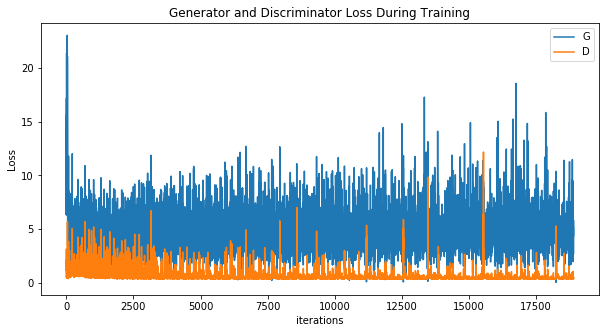

In [9]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

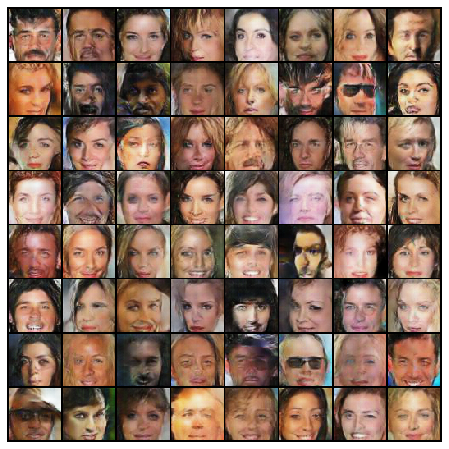

In [10]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]

Upon performing Training of the DCGAN model, it is obeserved that the model is able to generate Face images quite similar to the input images. 

Also, by tracking the loss values for both neural networks, it can be decided whether or not to re-train the model with more iterations to enhance image generation.

# II. Predicting DCGAN

In [8]:
output_dir = './data/celeba/dcgan_results/'

In [9]:
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [10]:
# Loading the Generator State from the training phase
generator = Generator(ngpu).to(device)
checkpoint = torch.load('./data/celeba/checkpoints/checkpoint.pth.tar')
generator.load_state_dict(checkpoint['state_dict2'])
print("Generator Info:")
print(generator)

Generator Info:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [11]:
# Sample a batch from generator
sample_batch_z = torch.randn(batch_size, nz, 1, 1).to(device)

In [12]:
# Function for performing Image Prediction
def predict():
    # sample images from generator
    fake_batch_images = generator(sample_batch_z)
    vutils.save_image(fake_batch_images.detach(), "%s/sample_from_generator_with_seed_{%d}.png" %
                                   (output_dir, manualSeed), normalize=True)

In [13]:
# Function for plotting the predicted image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.figure(figsize=(10,5))
    plt.show()

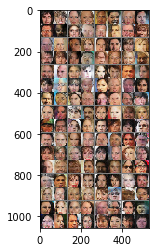

<Figure size 720x360 with 0 Axes>

Sampling Done! Image saved at ./data/celeba/dcgan_results//sample_from_generator_with_seed_{7436}.png


In [14]:
predict()
imshow(vutils.make_grid(generator(sample_batch_z).detach()))
print("Sampling Done! Image saved at %s/sample_from_generator_with_seed_{%d}.png" % ((output_dir, manualSeed)))

In [15]:
# Calculating the inception score for the predicted image
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the logs
    is_score = mpmath.exp(avg_kl_d)
    return is_score

In [16]:
# Conditional probabilities for high quality images
test_data = './data/celeba/dcgan_results/sample_from_generator_with_seed_{7436}.png'
output_dir = cv2.imread(test_data,cv2.IMREAD_UNCHANGED)

p_yx = asarray(output_dir)
score = calculate_inception_score(p_yx)
print(score)

3.53784902618704e+3787


##### Inception value = 33685.228103

Upon performing Image Prediction, it is stated that the model has been trained adequately to generate good images and predict similar images to the the input data.

The Prediction model has been evaluated using the formula of Inception Score and have acheieved good results.

# III. Image Inpainting with DCGAN

In [20]:
num_iters = 2000
lamd = 0.1
save_dir = './data/celeba/inpainted_data'

test_data = './data/celeba/resized_celeba/data/000046.jpg'

In [21]:
# Loading Generator and Discriminator Networks
generator = Generator(ngpu)
discriminator = Discriminator(ngpu)

# Moving generator and disciminator to cuda device
generator.to(device)
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [22]:
# loading Generator and Discriminator network states
checkpoint = torch.load('./data/celeba/checkpoints/checkpoint.pth.tar')
print("load trained state dict from local files...")
generator.load_state_dict(checkpoint['state_dict2'])
discriminator.load_state_dict(checkpoint['state_dict1'])
print("generator and discriminator state dict loaded, done.")

print("Generator Info:")
print(generator)
print("Discriminator Info:")
print(discriminator)

load trained state dict from local files...
generator and discriminator state dict loaded, done.
Generator Info:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
 

In [23]:
image_shape = [nc, image_size, image_size]

criteria = nn.BCELoss()

In [24]:
# Function for performing Image Inpainting
def impainting():
    # Create output folder
    source_imagedir = os.path.join(save_dir, "source_images")
    masked_imagedir = os.path.join(save_dir, "masked_images")
    impainted_imagedir = os.path.join(save_dir, "impainted_images")
    os.makedirs(source_imagedir, exist_ok=True)
    os.makedirs(masked_imagedir,exist_ok=True)
    os.makedirs(impainted_imagedir,exist_ok=True)
    
    # How many pictures need to be repaired in total
    num_images = len(test_data)
    # How many batches can be divided into total for processing
    num_batches = int(np.ceil(num_images / batch_size))
    for idx in range(num_batches):
        # Perform the following processing for each batch image
        lidx = idx * batch_size
        hidx = min(num_images, (idx + 1) * batch_size)
        realBatchSize = hidx - lidx

        batch_images = [get_tensor_image(imgpath) for imgpath in glob.glob(test_data[lidx:hidx])]
        batch_images = torch.stack(batch_images).to(device)
        
        # The input original picture is ready, start to prepare the mask
        # Temporarily only provide center mask
        mask = torch.ones(size=image_shape).to(device)
        imageCenterScale = 0.3
        lm = int(image_size * imageCenterScale)
        hm = int(image_size * (1 - imageCenterScale))
        #Mask the center of the image to 0
        mask[:,lm:hm, lm:hm] = 0.0
        masked_batch_images = torch.mul(batch_images, mask).to(device)
        
        # First save the original picture and masked picture
        save_tensor_images(batch_images.detach(),
                   os.path.join(source_imagedir,"source_image_batch_{}.png".format(idx)))
    
        save_tensor_images(masked_batch_images.detach(), os.path.join(masked_imagedir, "masked_image_batch_{}.png".format(idx)))

       
        z_hat = torch.rand(size=[realBatchSize,nz,1,1],dtype=torch.float32,requires_grad=True,device=device)
        z_hat.data.mul_(2.0).sub_(1.0)
        opt = optim.Adam([z_hat],lr=learning_rate)       
        print("start impainting iteration for batch : {}".format(idx))
        v = torch.tensor(0,dtype=torch.float32,device=device)
        m = torch.tensor(0,dtype=torch.float32,device=device)
        
        for iteration in range(num_iters):
            # Iterate impainting for each batch image separately
            if z_hat.grad is not None:
                z_hat.grad.data.zero_()
            generator.zero_grad()
            discriminator.zero_grad()
            batch_images_g = generator(z_hat)
            batch_images_g_masked = torch.mul(batch_images_g,mask) 
            impainting_images = torch.mul(batch_images_g,(1-mask)) + masked_batch_images
            if iteration % 100==0:
                # Save impainting picture result
                print("\nsaving impainted images for batch: {} , iteration:{}".format(idx,iteration))
                save_tensor_images(impainting_images.detach(), os.path.join(impainted_imagedir,
                                                        "impainted_image_batch_{}_iteration_{}.png".format(idx,iteration)))

            loss_context = torch.norm(
                (masked_batch_images-batch_images_g_masked),p=1)
            dis_output = discriminator(impainting_images)

            batch_labels = torch.full((realBatchSize,), 1, device=device)
            loss_perceptual = criteria(dis_output,batch_labels)
            
            total_loss = loss_context + lamd*loss_perceptual
            print("\r batch {} : iteration : {:4} , context_loss:{:.4f},
                  perceptual_loss:{:4f}".format(idx,iteration,loss_context,loss_perceptual),end="")
            total_loss.backward()
            opt.step()

In [25]:
impainting()

start impainting iteration for batch : 0

saving impainted images for batch: 0 , iteration:0


..\aten\src\ATen\native\TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


 batch 0 : iteration :   99 , context_loss:176137.3750,perceptual_loss:6.865256
saving impainted images for batch: 0 , iteration:100
 batch 0 : iteration :  199 , context_loss:164194.1719,perceptual_loss:6.796547
saving impainted images for batch: 0 , iteration:200
 batch 0 : iteration :  299 , context_loss:154829.9531,perceptual_loss:6.773660
saving impainted images for batch: 0 , iteration:300
 batch 0 : iteration :  399 , context_loss:146957.3438,perceptual_loss:6.781808
saving impainted images for batch: 0 , iteration:400
 batch 0 : iteration :  499 , context_loss:140088.2812,perceptual_loss:6.780982
saving impainted images for batch: 0 , iteration:500
 batch 0 : iteration :  599 , context_loss:134046.6875,perceptual_loss:6.767390
saving impainted images for batch: 0 , iteration:600
 batch 0 : iteration :  699 , context_loss:128856.5000,perceptual_loss:6.747256
saving impainted images for batch: 0 , iteration:700
 batch 0 : iteration :  799 , context_loss:124442.3906,perceptual_los

Upon performing Image Inpainting application on the Celeb-A Faces Test Dataset, it is observed that the images are reconstructed from masked images, maintaining their Contextual and Perceptual Information from original images.

## Conlusion for Experiment 1:

From this experiment it is observed that good training, prediction and inpainting results are obtained for the Celeb-A faces dataset. This is due to the similarity in nature of the dataset as mentioned earlier.

There are some uncertainties related to few generated images, but the images generated are better with the implementation of the Prediction model. The next experiment will focus on the 2nd scenario of the complexity of image.